<a href="https://colab.research.google.com/github/looktei/Hand-on-practice_Molecular_Docking/blob/main/Completed__STT49_Abstract_workbook_AI_ML_Drug_Design_Napat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. Quantitative structure–activity relationship (QSARS) models using Machine Learning**

# 1.1 System preparation & preprocessing

 **a) Install dependencies & Import Libraries**

In [1]:
## RDKit Libraries
! pip install rdkit-pypi
!cat  /etc/lsb-release
import sys
print(sys.path)
import rdkit
from rdkit import Chem
from IPython import display
from rdkit.Chem.Draw import IPythonConsole
from IPython.display import display
import pandas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 33.0 MB/s eta 0:00:00
DISTRIB_ID=Ubuntu
DISTRIB_RELEASE=22.04
DISTRIB_CODENAME=jammy
DISTRIB_DESCRIPTION="Ubuntu 22.04.3 LTS"
['/content', '/env/python', '/usr/lib/python310.zip', '/usr/lib/python3.10', '/usr/lib/python3.10/lib-dynload', '', '/usr/local/lib/python3.10/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.10/dist-packages/IPython/extensions', '/root/.ipython']


In [2]:
###import RDKIT ###
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.SaltRemover import SaltRemover
from rdkit.Chem import MolFromSmiles, MolToSmiles
from rdkit.Chem.inchi import MolToInchiKey
from rdkit.Chem import Descriptors
from rdkit.Chem.rdMolDescriptors import CalcMolFormula

In [3]:
## chembl-webresource-client 0.10.8
!pip install chembl-webresource-client

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.2/55.2 kB 664.9 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 6.0 MB/s eta 0:00:00
  Attempting uninstall: attrs
    Found existing installation: attrs 23.1.0
    Uninstalling attrs-23.1.0:
      Successfully uninstalled attrs-23.1.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is not installed.
jsonschema 4.19.2 requires attrs>=22.2.0, but you have attrs 21.4.0 which is incompatible.
referencing 0.31.0 requires attrs>=22.2.0, but you have attrs 21.4.0 which is incompatible.


In [4]:
## Import essential libraries
import pandas as pd
import numpy as np
import plotly
import plotly.io as pio
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import requests
import xml.etree.ElementTree as ET
from pandas import json_normalize
import json
import math
import multiprocessing as mp
import ast
import sys
import os
import requests
import subprocess
import shutil
from logging import getLogger, StreamHandler, INFO

**b) Set up working directory in Google Colab & Google Drive**

In [5]:
# Setup PATH
from google.colab import drive
drive.mount('/content/drive')
import os

# set Your own drive.
location = os.path.normpath('/content/drive/MyDrive/SARS-CoV-2_Mpro-2_STT49_final')
print(location)
targetName = 'SARS-CoV-2_Mpro'
path = os.path.join(location, "target_" + targetName)
print(path)

Mounted at /content/drive
/content/drive/MyDrive/SARS-CoV-2_Mpro-2_STT49_final
/content/drive/MyDrive/SARS-CoV-2_Mpro-2_STT49_final/target_SARS-CoV-2_Mpro


# 1.2 Retrive biological data from  databases (e.g. uniprot, chembl database)

In [6]:
# Define primary variables for data retrival
title = 'chembl'
target = ['SARS-CoV-2_Mpro']
targetName = 'SARS-CoV-2_Mpro'
uniID = 'P0DTD1'
targetName = uniID
path = os.path.join(location, "target_" + uniID)
# Making Directory
if not os.path.exists(os.path.join(location, "target_" + uniID)):
    os.makedirs(os.path.join(location, "target_" + uniID))

# 1.3 Convert UniProtID to ChEMBLID

In [7]:
# Convert UniProtID to ChEMBLID
from chembl_webresource_client.new_client import new_client
pd.options.mode.chained_assignment = None

print("Working on: UniProtID " + uniID)

target = new_client.target.filter(target_components__accession=uniID)
# Load targets in data frame
targetsDF = pd.DataFrame(target)
# Target doesn't exist in Chembl
response = ''
if targetsDF.empty:
    print("Bad Target: " + uniID)
    response = "Target doesn't not exist in Chembl."
    print(response)

targetID = targetsDF.at[0, 'target_chembl_id']
print("Working on: ChEMBL " + targetID)

Working on: UniProtID P0DTD1
Working on: ChEMBL CHEMBL4523582


# 1.4 Get Bioactivities with targetID

In [8]:
# Get Bioactivities with targetID

def Chembl_Activity_REST(chemblID):
    actdf = pd.DataFrame()
    resp = requests.get('https://www.ebi.ac.uk/chembl/api/data/activity.json?target_chembl_id__exact=' + chemblID + '&limit=1000')
    if resp.status_code != 200:
        # This means something went wrong.
        print("Error: " + str((resp.status_code)))
    res = resp.json()
    actdf = pd.DataFrame(res.get('activities'))
    meta = res.get('page_meta')
    if meta['next']:
        url = ("https://www.ebi.ac.uk" + str(meta['next']))
    while (meta['next']):
        resp = requests.get(url)
        if resp.status_code != 200:
            # This means something went wrong.
            print("Error: " + str((resp.status_code)))
        res = resp.json()
        temp = pd.DataFrame(res.get('activities'))
        actdf = actdf.append(temp)
        meta = res.get('page_meta')
        url = ("https://www.ebi.ac.uk" + str(meta['next']))
    return actdf

# Get Bioactivities with targetID (take very long time for many activity compounds)
ActsDF = Chembl_Activity_REST(targetID)
ActsDF = pd.DataFrame(ActsDF)
display(ActsDF.head(), len(ActsDF))

<ipython-input-8-16de691d81dd>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  actdf = actdf.append(temp)
<ipython-input-8-16de691d81dd>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  actdf = actdf.append(temp)
<ipython-input-8-16de691d81dd>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  actdf = actdf.append(temp)
<ipython-input-8-16de691d81dd>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  actdf = actdf.append(temp)
<ipython-input-8-16de691d81dd>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  actdf = actdf.append(temp)
<ipython-input-

,action_type,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,assay_variant_accession,assay_variant_mutation,bao_endpoint,...,target_organism,target_pref_name,target_tax_id,text_value,toid,type,units,uo_units,upper_value,value
0,None,None,19955497,[],CHEMBL4495582,SARS-CoV-2 3CL-Pro protease inhibition percent...,F,None,None,BAO_0000201,...,Severe acute respiratory syndrome coronavirus 2,Replicase polyprotein 1ab,2697049,None,None,Inhibition,%,UO_0000187,None,29.96
1,None,None,19955498,[],CHEMBL4495582,SARS-CoV-2 3CL-Pro protease inhibition percent...,F,None,None,BAO_0000201,...,Severe acute respiratory syndrome coronavirus 2,Replicase polyprotein 1ab,2697049,None,None,Inhibition,%,UO_0000187,None,21.72
2,None,None,19955499,[],CHEMBL4495582,SARS-CoV-2 3CL-Pro protease inhibition percent...,F,None,None,BAO_0000201,...,Severe acute respiratory syndrome coronavirus 2,Replicase polyprotein 1ab,2697049,None,None,Inhibition,%,UO_0000187,None,24.9
3,None,None,19955500,[],CHEMBL4495582,SARS-CoV-2 3CL-Pro protease inhibition percent...,F,None,None,BAO_0000201,...,Severe acute respiratory syndrome coronavirus 2,Replicase polyprotein 1ab,2697049,None,None,Inhibition,%,UO_0000187,None,38.63
4,None,None,19955501,[],CHEMBL4495582,SARS-CoV-2 3CL-Pro protease inhibition percent...,F,None,None,BAO_0000201,...,Severe acute respiratory syndrome coronavirus 2,Replicase polyprotein 1ab,2697049,None,None,Inhibition,%,UO_0000187,None,22.96


10691

# 1.5 Get Assay with targetID (for confidence score)

In [9]:
# Get Assay with targetID, for confidence score

def Chembl_Assay_REST(chemblID):
    actdf = pd.DataFrame()
    resp = requests.get(
        'https://www.ebi.ac.uk/chembl/api/data/assay.json?target_chembl_id__exact=' + chemblID + '&limit=1000')
    if resp.status_code != 200:
        # This means something went wrong.
        print("Error: " + str((resp.status_code)))
    res = resp.json()
    actdf = pd.DataFrame(res.get('assays'))
    meta = res.get('page_meta')
    if meta['next']:
        url = ("https://www.ebi.ac.uk" + str(meta['next']))
    while (meta['next']):
        resp = requests.get(url)
        if resp.status_code != 200:
            # This means something went wrong.
            print("Error: " + str((resp.status_code)))
        res = resp.json()
        temp = pd.DataFrame(res.get('activities'))
        actdf = actdf.append(temp)
        meta = res.get('page_meta')
        url = ("https://www.ebi.ac.uk" + str(meta['next']))
    return actdf

# Get Assay with targetID, for confidence score
# assayDF = new_client.assay.filter(target_chembl_id=targetID)
assayDF = Chembl_Assay_REST(targetID)
assayDF = pd.DataFrame(assayDF)
display(assayDF.head(), len(assayDF))

,aidx,assay_category,assay_cell_type,assay_chembl_id,assay_classifications,assay_organism,assay_parameters,assay_strain,assay_subcellular_fraction,assay_tax_id,...,confidence_score,description,document_chembl_id,relationship_description,relationship_type,src_assay_id,src_id,target_chembl_id,tissue_chembl_id,variant_sequence
0,1_KUZ,None,None,CHEMBL4495582,[],Severe acute respiratory syndrome coronavirus 2,[],None,None,2697049,...,9,SARS-CoV-2 3CL-Pro protease inhibition percent...,CHEMBL4495564,Direct protein target assigned,D,None,52,CHEMBL4523582,None,None
1,2_KUZ,None,None,CHEMBL4495583,[],Severe acute respiratory syndrome coronavirus 2,[],None,None,2697049,...,9,SARS-CoV-2 3CL-Pro protease inhibition IC50 de...,CHEMBL4495564,Direct protein target assigned,D,None,52,CHEMBL4523582,None,None
2,1321489,None,None,CHEMBL4810314,[],Severe acute respiratory syndrome coronavirus 2,[],None,None,2697049,...,9,Inhibition of SARS-CoV-2 3CLpro preincubated f...,CHEMBL4808212,Direct protein target assigned,D,None,1,CHEMBL4523582,None,None
3,1322386,None,None,CHEMBL4810315,[],Severe acute respiratory syndrome coronavirus 2,[],None,None,2697049,...,9,Inhibition of recombinant SARS CoV-2 main prot...,CHEMBL4808212,Direct protein target assigned,D,None,1,CHEMBL4523582,None,None
4,1322391,None,None,CHEMBL4810316,[],Severe acute respiratory syndrome coronavirus 2,[],None,None,2697049,...,9,Inhibition of recombinant SARS-CoV-2 Main prot...,CHEMBL4808212,Direct protein target assigned,D,None,1,CHEMBL4523582,None,None


267

In [10]:
# Check bad target: number of bioactivity and assay
# Bad Targets
if len(ActsDF) == 0 or len(assayDF) == 0:
    print("Bad Target: " + uniID)
    response = "Target has no associated bioactivity or binding type assay."
    print(response)

# 1.6 Merge both DFs (Biological activities and Assay with TargetID) & Store all bioactivity in ".csv file"

In [11]:
# Merge both DFs
bioactsDF = pd.merge(ActsDF, assayDF[['assay_chembl_id', 'confidence_score', 'assay_organism']], how='inner', on='assay_chembl_id')
print(len(bioactsDF))
# Drop values contain Empty values
bioactsDF['value'].replace('', np.nan, inplace=True)
bioactsDF.dropna(subset=['value'], inplace=True)
# Drop operator contain Empty values
bioactsDF['relation'].replace('', np.nan, inplace=True)
bioactsDF.dropna(subset=['relation'], inplace=True)

display(bioactsDF.head(), len(bioactsDF))

# Store all bioactivity
bioactsDF.to_csv(os.path.join(path, "bioacts_all.csv"))

10691


,action_type,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,assay_variant_accession,assay_variant_mutation,bao_endpoint,...,target_tax_id,text_value,toid,type,units,uo_units,upper_value,value,confidence_score,assay_organism
0,None,None,19955497,[],CHEMBL4495582,SARS-CoV-2 3CL-Pro protease inhibition percent...,F,None,None,BAO_0000201,...,2697049,None,None,Inhibition,%,UO_0000187,None,29.96,9,Severe acute respiratory syndrome coronavirus 2
1,None,None,19955498,[],CHEMBL4495582,SARS-CoV-2 3CL-Pro protease inhibition percent...,F,None,None,BAO_0000201,...,2697049,None,None,Inhibition,%,UO_0000187,None,21.72,9,Severe acute respiratory syndrome coronavirus 2
2,None,None,19955499,[],CHEMBL4495582,SARS-CoV-2 3CL-Pro protease inhibition percent...,F,None,None,BAO_0000201,...,2697049,None,None,Inhibition,%,UO_0000187,None,24.9,9,Severe acute respiratory syndrome coronavirus 2
3,None,None,19955500,[],CHEMBL4495582,SARS-CoV-2 3CL-Pro protease inhibition percent...,F,None,None,BAO_0000201,...,2697049,None,None,Inhibition,%,UO_0000187,None,38.63,9,Severe acute respiratory syndrome coronavirus 2
4,None,None,19955501,[],CHEMBL4495582,SARS-CoV-2 3CL-Pro protease inhibition percent...,F,None,None,BAO_0000201,...,2697049,None,None,Inhibition,%,UO_0000187,None,22.96,9,Severe acute respiratory syndrome coronavirus 2


10493

# 1.7 Check Target information

In [12]:
# # Making Directory
# if not os.path.exists(os.path.join(location, "_" + uniID)):
#     os.makedirs(os.path.join(location, "_" + uniID))

# Target Information from ChEMBL
def targetinformation(location, uniID):
    print(uniID)
    requestURL = "https://www.ebi.ac.uk/proteins/api/proteins?accession=" + uniID
    r = requests.get(requestURL, headers={"Accept": "application/json"})
    df = json_normalize(json.loads(r.text))
    u = df['accession'].values[0]
    rv = df['info.type'].values[0]
    gn = pd.Series([i[0]['name']['value'] if str(i) != "nan" and 'name' in i[0].keys() else np.nan for i in df['gene']]).values[0]
    fn = df['protein.recommendedName.fullName.value'].values[0]
    allinfo = [u, fn, gn, rv]

    print(allinfo)

targetinformation(location, uniID)

P0DTD1
['P0DTD1', 'Replicase polyprotein 1ab', 'rep', 'Swiss-Prot']


In [13]:
## Target Information from ChEMBL ##
# Define threshold
confidence_threshold = [9]
assay_threshold = ['B']
bioact_threshold = ['IC50', 'pIC50']
data_validity_comment = ['Manually validated']

bioactsFiltered = pd.read_csv(os.path.join(path, "bioacts_all.csv"), index_col=0)
bioactsFiltered = bioactsFiltered[bioactsFiltered['confidence_score'].isin(confidence_threshold)]  # Direct single protein target assigned
bioactsFiltered = bioactsFiltered[bioactsFiltered['assay_type'].isin(assay_threshold)]  # only binding data
bioactsFiltered = bioactsFiltered[(bioactsFiltered['data_validity_comment'] != bioactsFiltered['data_validity_comment']) | (bioactsFiltered['data_validity_comment'].isin(data_validity_comment))]
bioactsFiltered = bioactsFiltered[bioactsFiltered['standard_type'].isin(bioact_threshold)]  # only IC50 and pIC50 data
bioactsFiltered = bioactsFiltered[bioactsFiltered['standard_value'] != 0]
# bioactsFiltered['standard_valueX'] = bioactsFiltered['standard_value'].apply(pd.to_numeric)
bioactsFiltered = bioactsFiltered.reset_index(drop=True)

# Bad Targets
if len(bioactsFiltered) == 0:
    print("Bad Target: " + uniID)
    response = "Target has no bioactivity type IC50 with confidence score and assay type that you have selected"
    print(response)

display(bioactsFiltered.head(), len(bioactsFiltered))

,action_type,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,assay_variant_accession,assay_variant_mutation,bao_endpoint,...,target_tax_id,text_value,toid,type,units,uo_units,upper_value,value,confidence_score,assay_organism
0,"{'action_type': 'INHIBITOR', 'description': 'N...",NaN,23150136,"[{'comments': None, 'relation': '=', 'result_f...",CHEMBL4810314,Inhibition of SARS-CoV-2 3CLpro preincubated f...,B,NaN,NaN,BAO_0000190,...,2697049,NaN,NaN,IC50,uM,UO_0000065,NaN,0.094,9,Severe acute respiratory syndrome coronavirus 2
1,"{'action_type': 'INHIBITOR', 'description': 'N...",NaN,23150137,"[{'comments': None, 'relation': '=', 'result_f...",CHEMBL4810314,Inhibition of SARS-CoV-2 3CLpro preincubated f...,B,NaN,NaN,BAO_0000190,...,2697049,NaN,NaN,IC50,uM,UO_0000065,NaN,0.286,9,Severe acute respiratory syndrome coronavirus 2
2,"{'action_type': 'INHIBITOR', 'description': 'N...",NaN,23150138,"[{'comments': None, 'relation': '=', 'result_f...",CHEMBL4810314,Inhibition of SARS-CoV-2 3CLpro preincubated f...,B,NaN,NaN,BAO_0000190,...,2697049,NaN,NaN,IC50,uM,UO_0000065,NaN,0.014,9,Severe acute respiratory syndrome coronavirus 2
3,"{'action_type': 'INHIBITOR', 'description': 'N...",NaN,23150139,"[{'comments': None, 'relation': '=', 'result_f...",CHEMBL4810314,Inhibition of SARS-CoV-2 3CLpro preincubated f...,B,NaN,NaN,BAO_0000190,...,2697049,NaN,NaN,IC50,uM,UO_0000065,NaN,0.023,9,Severe acute respiratory syndrome coronavirus 2
4,"{'action_type': 'INHIBITOR', 'description': 'N...",NaN,23150140,"[{'comments': None, 'relation': '=', 'result_f...",CHEMBL4810314,Inhibition of SARS-CoV-2 3CLpro preincubated f...,B,NaN,NaN,BAO_0000190,...,2697049,NaN,NaN,IC50,uM,UO_0000065,NaN,0.065,9,Severe acute respiratory syndrome coronavirus 2


1015

# 1.8 Define threshold with confidence, assay type, bioactivities, data validity comment

In [14]:
# Define threshold
confidence_threshold = [9]
assay_threshold = ['B']
bioact_threshold = ['IC50', 'pIC50']
data_validity_comment = ['Manually validated']

bioactsFiltered = pd.read_csv(os.path.join(path, "bioacts_all.csv"), index_col=0)
bioactsFiltered = bioactsFiltered[bioactsFiltered['confidence_score'].isin(confidence_threshold)]  # Direct single protein target assigned
bioactsFiltered = bioactsFiltered[bioactsFiltered['assay_type'].isin(assay_threshold)]  # only binding data
bioactsFiltered = bioactsFiltered[(bioactsFiltered['data_validity_comment'] != bioactsFiltered['data_validity_comment']) | (bioactsFiltered['data_validity_comment'].isin(data_validity_comment))]
bioactsFiltered = bioactsFiltered[bioactsFiltered['standard_type'].isin(bioact_threshold)]  # only IC50 and pIC50 data
bioactsFiltered = bioactsFiltered[bioactsFiltered['standard_value'] != 0]
# bioactsFiltered['standard_valueX'] = bioactsFiltered['standard_value'].apply(pd.to_numeric)
bioactsFiltered = bioactsFiltered.reset_index(drop=True)

# Bad Targets
if len(bioactsFiltered) == 0:
    print("Bad Target: " + uniID)
    response = "Target has no bioactivity type IC50 with confidence score and assay type that you have selected"
    print(response)

display(bioactsFiltered.head(), len(bioactsFiltered))

,action_type,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,assay_variant_accession,assay_variant_mutation,bao_endpoint,...,target_tax_id,text_value,toid,type,units,uo_units,upper_value,value,confidence_score,assay_organism
0,"{'action_type': 'INHIBITOR', 'description': 'N...",NaN,23150136,"[{'comments': None, 'relation': '=', 'result_f...",CHEMBL4810314,Inhibition of SARS-CoV-2 3CLpro preincubated f...,B,NaN,NaN,BAO_0000190,...,2697049,NaN,NaN,IC50,uM,UO_0000065,NaN,0.094,9,Severe acute respiratory syndrome coronavirus 2
1,"{'action_type': 'INHIBITOR', 'description': 'N...",NaN,23150137,"[{'comments': None, 'relation': '=', 'result_f...",CHEMBL4810314,Inhibition of SARS-CoV-2 3CLpro preincubated f...,B,NaN,NaN,BAO_0000190,...,2697049,NaN,NaN,IC50,uM,UO_0000065,NaN,0.286,9,Severe acute respiratory syndrome coronavirus 2
2,"{'action_type': 'INHIBITOR', 'description': 'N...",NaN,23150138,"[{'comments': None, 'relation': '=', 'result_f...",CHEMBL4810314,Inhibition of SARS-CoV-2 3CLpro preincubated f...,B,NaN,NaN,BAO_0000190,...,2697049,NaN,NaN,IC50,uM,UO_0000065,NaN,0.014,9,Severe acute respiratory syndrome coronavirus 2
3,"{'action_type': 'INHIBITOR', 'description': 'N...",NaN,23150139,"[{'comments': None, 'relation': '=', 'result_f...",CHEMBL4810314,Inhibition of SARS-CoV-2 3CLpro preincubated f...,B,NaN,NaN,BAO_0000190,...,2697049,NaN,NaN,IC50,uM,UO_0000065,NaN,0.023,9,Severe acute respiratory syndrome coronavirus 2
4,"{'action_type': 'INHIBITOR', 'description': 'N...",NaN,23150140,"[{'comments': None, 'relation': '=', 'result_f...",CHEMBL4810314,Inhibition of SARS-CoV-2 3CLpro preincubated f...,B,NaN,NaN,BAO_0000190,...,2697049,NaN,NaN,IC50,uM,UO_0000065,NaN,0.065,9,Severe acute respiratory syndrome coronavirus 2


1015

# 1.9 Clean smiles & save output file (csv file, smi file)

In [15]:
# clean smiles
def clean_smiles(df):
    remover = SaltRemover()
    SMILES_desalt = []
    inchi = []
    bad_keys = []
    for i in df.canonical_smiles:
        mol = MolFromSmiles(i)
        if mol:
            mol_desalt = remover.StripMol(mol)
            mol_SMILES = MolToSmiles(mol_desalt)
            SMILES_desalt.append(mol_SMILES)
            inchi.append(MolToInchiKey(mol))
        else:
            bad_keys.append(i)

    df = df[~df['canonical_smiles'].isin(bad_keys)]
    df['SMILES_desalt'] = SMILES_desalt
    df['mol'] = mol
    df['InChIKey'] = inchi
    df2 = df

    return df2


bioactsFiltered_cleaned = clean_smiles(bioactsFiltered)
print("Number: " + str(len(bioactsFiltered_cleaned)))
display(bioactsFiltered_cleaned.head())

Number: 1015


,action_type,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,assay_variant_accession,assay_variant_mutation,bao_endpoint,...,type,units,uo_units,upper_value,value,confidence_score,assay_organism,SMILES_desalt,mol,InChIKey
0,"{'action_type': 'INHIBITOR', 'description': 'N...",NaN,23150136,"[{'comments': None, 'relation': '=', 'result_f...",CHEMBL4810314,Inhibition of SARS-CoV-2 3CLpro preincubated f...,B,NaN,NaN,BAO_0000190,...,IC50,uM,UO_0000065,NaN,0.094,9,Severe acute respiratory syndrome coronavirus 2,CC(C)C[C@H](NC(=O)[C@@H](NC(=O)OCc1ccccc1)C(C)...,<rdkit.Chem.rdchem.Mol object at 0x789cf7a435a0>,KSCRVOKQPYZBHZ-IXPOFIJOSA-N
1,"{'action_type': 'INHIBITOR', 'description': 'N...",NaN,23150137,"[{'comments': None, 'relation': '=', 'result_f...",CHEMBL4810314,Inhibition of SARS-CoV-2 3CLpro preincubated f...,B,NaN,NaN,BAO_0000190,...,IC50,uM,UO_0000065,NaN,0.286,9,Severe acute respiratory syndrome coronavirus 2,CCOC(=O)/C=C/[C@H](C[C@@H]1CCNC1=O)NC(=O)[C@H]...,<rdkit.Chem.rdchem.Mol object at 0x789cf7a435a0>,WDMSWWUPIMEGNZ-SGFFKCJDSA-N
2,"{'action_type': 'INHIBITOR', 'description': 'N...",NaN,23150138,"[{'comments': None, 'relation': '=', 'result_f...",CHEMBL4810314,Inhibition of SARS-CoV-2 3CLpro preincubated f...,B,NaN,NaN,BAO_0000190,...,IC50,uM,UO_0000065,NaN,0.014,9,Severe acute respiratory syndrome coronavirus 2,O=C[C@H](C[C@@H]1CCNC1=O)NC(=O)[C@H](CC1CCCCC1...,<rdkit.Chem.rdchem.Mol object at 0x789cf7a435a0>,HPKJGHVHQWJOOT-ZJOUEHCJSA-N
3,"{'action_type': 'INHIBITOR', 'description': 'N...",NaN,23150139,"[{'comments': None, 'relation': '=', 'result_f...",CHEMBL4810314,Inhibition of SARS-CoV-2 3CLpro preincubated f...,B,NaN,NaN,BAO_0000190,...,IC50,uM,UO_0000065,NaN,0.023,9,Severe acute respiratory syndrome coronavirus 2,O=C[C@H](C[C@@H]1CCNC1=O)NC(=O)[C@H](Cc1cccc(F...,<rdkit.Chem.rdchem.Mol object at 0x789cf7a435a0>,HCRBVFBQANEDDM-CUWPLCDZSA-N
4,"{'action_type': 'INHIBITOR', 'description': 'N...",NaN,23150140,"[{'comments': None, 'relation': '=', 'result_f...",CHEMBL4810314,Inhibition of SARS-CoV-2 3CLpro preincubated f...,B,NaN,NaN,BAO_0000190,...,IC50,uM,UO_0000065,NaN,0.065,9,Severe acute respiratory syndrome coronavirus 2,CC(C)C[C@H](NC(=O)OCc1ccccc1)C(=O)N[C@@H](CC(C...,<rdkit.Chem.rdchem.Mol object at 0x789cf7a435a0>,HEVXFSPURLYARR-QORCZRPOSA-N


In [16]:
# Output csv files
bioactsFiltered_cleaned.to_csv(os.path.join(path, 'bioactsFiltered_cleaned.csv'), index=False)

# Output smi files
tempdf = bioactsFiltered_cleaned[['SMILES_desalt', 'InChIKey']]
tempdf.to_csv(os.path.join(path, 'bioactsFiltered_cleaned.smi'), sep='\t', header=False, index=False)

# 1.10 Get Information Lipinski rule of five (RO5) and formula into SMILES using RDKit module

In [17]:
# Get info R05 and formula from RDKit

bioactsCleaned = pd.read_csv(os.path.join(path, "bioactsFiltered_cleaned.csv"), header=0)

mols = []
for i in bioactsCleaned['SMILES_desalt']:
    mol = MolFromSmiles(i)
    mols.append(mol)

MW = [Descriptors.MolWt(n) for n in mols]
LogP = [Descriptors.MolLogP(o) for o in mols]
nHAcc = [Descriptors.NumHAcceptors(p) for p in mols]
nHDon = [Descriptors.NumHDonors(q) for q in mols]
stdInChiKey = bioactsCleaned['InChIKey']
formula = [CalcMolFormula(f) for f in mols]
smiles = bioactsCleaned['SMILES_desalt']
preferredCompoundName = []
for i in bioactsCleaned['molecule_pref_name']:
    if i is not np.NaN:
        preferredCompoundName.append(i)
    else:
        preferredCompoundName.append('-')

bioactsCleaned['MW'] = MW
bioactsCleaned['LogP'] = LogP
bioactsCleaned['nHAcc'] = nHAcc
bioactsCleaned['nHDon'] = nHDon
bioactsCleaned['formula'] = formula
bioactsCleaned['preferredCompoundName'] = preferredCompoundName
display(bioactsCleaned, len(bioactsCleaned))

,action_type,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,assay_variant_accession,assay_variant_mutation,bao_endpoint,...,assay_organism,SMILES_desalt,mol,InChIKey,MW,LogP,nHAcc,nHDon,formula,preferredCompoundName
0,"{'action_type': 'INHIBITOR', 'description': 'N...",NaN,23150136,"[{'comments': None, 'relation': '=', 'result_f...",CHEMBL4810314,Inhibition of SARS-CoV-2 3CLpro preincubated f...,B,NaN,NaN,BAO_0000190,...,Severe acute respiratory syndrome coronavirus 2,CC(C)C[C@H](NC(=O)[C@@H](NC(=O)OCc1ccccc1)C(C)...,<rdkit.Chem.rdchem.Mol object at 0x789cf7a435a0>,KSCRVOKQPYZBHZ-IXPOFIJOSA-N,635.787000,3.9719,8,4,C33H41N5O6S,-
1,"{'action_type': 'INHIBITOR', 'description': 'N...",NaN,23150137,"[{'comments': None, 'relation': '=', 'result_f...",CHEMBL4810314,Inhibition of SARS-CoV-2 3CLpro preincubated f...,B,NaN,NaN,BAO_0000190,...,Severe acute respiratory syndrome coronavirus 2,CCOC(=O)/C=C/[C@H](C[C@@H]1CCNC1=O)NC(=O)[C@H]...,<rdkit.Chem.rdchem.Mol object at 0x789cf7a435a0>,WDMSWWUPIMEGNZ-SGFFKCJDSA-N,572.703000,2.5986,7,4,C30H44N4O7,-
2,"{'action_type': 'INHIBITOR', 'description': 'N...",NaN,23150138,"[{'comments': None, 'relation': '=', 'result_f...",CHEMBL4810314,Inhibition of SARS-CoV-2 3CLpro preincubated f...,B,NaN,NaN,BAO_0000190,...,Severe acute respiratory syndrome coronavirus 2,O=C[C@H](C[C@@H]1CCNC1=O)NC(=O)[C@H](CC1CCCCC1...,<rdkit.Chem.rdchem.Mol object at 0x789cf7a435a0>,HPKJGHVHQWJOOT-ZJOUEHCJSA-N,452.555000,2.4466,4,4,C25H32N4O4,-
3,"{'action_type': 'INHIBITOR', 'description': 'N...",NaN,23150139,"[{'comments': None, 'relation': '=', 'result_f...",CHEMBL4810314,Inhibition of SARS-CoV-2 3CLpro preincubated f...,B,NaN,NaN,BAO_0000190,...,Severe acute respiratory syndrome coronavirus 2,O=C[C@H](C[C@@H]1CCNC1=O)NC(=O)[C@H](Cc1cccc(F...,<rdkit.Chem.rdchem.Mol object at 0x789cf7a435a0>,HCRBVFBQANEDDM-CUWPLCDZSA-N,464.497000,1.8580,4,4,C25H25FN4O4,-
4,"{'action_type': 'INHIBITOR', 'description': 'N...",NaN,23150140,"[{'comments': None, 'relation': '=', 'result_f...",CHEMBL4810314,Inhibition of SARS-CoV-2 3CLpro preincubated f...,B,NaN,NaN,BAO_0000190,...,Severe acute respiratory syndrome coronavirus 2,CC(C)C[C@H](NC(=O)OCc1ccccc1)C(=O)N[C@@H](CC(C...,<rdkit.Chem.rdchem.Mol object at 0x789cf7a435a0>,HEVXFSPURLYARR-QORCZRPOSA-N,601.745000,1.9631,7,5,C31H47N5O7,-
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1010,"{'action_type': 'INHIBITOR', 'description': 'N...",NaN,24961281,"[{'comments': None, 'relation': '=', 'result_f...",CHEMBL5215875,Inhibition of SARS-CoV-2 3CLpro using FAM-SAVL...,B,NaN,NaN,BAO_0000190,...,Severe acute respiratory syndrome coronavirus 2,CC(C)C[C@H](NC(=O)OCCC12CC3CC(CC(C3)C1)C2)C(=O...,<rdkit.Chem.rdchem.Mol object at 0x789cf7a435a0>,PTOBNGNAWDQBAE-DQEADLMCSA-M,556.702000,1.6084,8,4,C26H42N3O8S-,-
1011,"{'action_type': 'INHIBITOR', 'description': 'N...",NaN,24961282,"[{'comments': None, 'relation': '=', 'result_f...",CHEMBL5215875,Inhibition of SARS-CoV-2 3CLpro using FAM-SAVL...,B,NaN,NaN,BAO_0000190,...,Severe acute respiratory syndrome coronavirus 2,CC(C)C[C@H](NC(=O)OCC12CC3CC(CC(O)(C3)C1)C2)C(...,<rdkit.Chem.rdchem.Mol object at 0x789cf7a435a0>,HCMUAXJAEVVGND-WUYKWXONSA-N,477.602000,1.6685,6,4,C25H39N3O6,-
1012,"{'action_type': 'INHIBITOR', 'description': 'N...",NaN,24961283,"[{'comments': None, 'relation': '=', 'result_f...",CHEMBL5215875,Inhibition of SARS-CoV-2 3CLpro using FAM-SAVL...,B,NaN,NaN,BAO_0000190,...,Severe acute respiratory syndrome coronavirus 2,CC(C)C[C@H](NC(=O)OCC12CC3CC(CC(O)(C3)C1)C2)C(...,<rdkit.Chem.rdchem.Mol object at 0x789cf7a435a0>,OXFCTAAAUSBQAO-TUAWEVJTSA-M,558.674000,0.3332,9,5,C25H40N3O9S-,-
1013,"{'action_type': 'INHIBITOR', 'description': 'N...",NaN,24961284,"[{'comments': None, 'relation': '=', 'result_f...",CHEMBL5215875,Inhibition of SARS-CoV-2 3CLpro using FAM-SAVL...,B,NaN,NaN,BAO_0000190,...,Severe acute respiratory syndrome coronavirus 2,[2H]C([2H])(OC(=O)N[C@

1015

# 1.11 Prepare Dataset  and convert Bioactivity (IC50) to pIC50

In [18]:
# Prepare Dataset convert to pIC50
IC50 = bioactsCleaned.copy()

# Collect pIC50 already first
pIC50_Already = pd.DataFrame()
if 'pIC50' in bioact_threshold:
    if len(IC50[IC50['standard_type'] == 'pIC50']) != 0:
        pIC50_Already = IC50[(IC50['standard_type'] == 'pIC50')]
        pIC50_Already['pIC50'] = pIC50_Already['standard_value']
        display(pIC50_Already.head())
        print(len(pIC50_Already))

# Collect IC50 already then
if 'IC50' in bioact_threshold:
    if len(IC50[IC50['standard_type'] == 'IC50']) != 0:
        IC50 = IC50[IC50['standard_type'] == 'IC50']
        display(IC50.head())
        print("There are: " + str(len(IC50)) + " IC50 bioactivity")

,action_type,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,assay_variant_accession,assay_variant_mutation,bao_endpoint,...,assay_organism,SMILES_desalt,mol,InChIKey,MW,LogP,nHAcc,nHDon,formula,preferredCompoundName
0,"{'action_type': 'INHIBITOR', 'description': 'N...",NaN,23150136,"[{'comments': None, 'relation': '=', 'result_f...",CHEMBL4810314,Inhibition of SARS-CoV-2 3CLpro preincubated f...,B,NaN,NaN,BAO_0000190,...,Severe acute respiratory syndrome coronavirus 2,CC(C)C[C@H](NC(=O)[C@@H](NC(=O)OCc1ccccc1)C(C)...,<rdkit.Chem.rdchem.Mol object at 0x789cf7a435a0>,KSCRVOKQPYZBHZ-IXPOFIJOSA-N,635.787,3.9719,8,4,C33H41N5O6S,-
1,"{'action_type': 'INHIBITOR', 'description': 'N...",NaN,23150137,"[{'comments': None, 'relation': '=', 'result_f...",CHEMBL4810314,Inhibition of SARS-CoV-2 3CLpro preincubated f...,B,NaN,NaN,BAO_0000190,...,Severe acute respiratory syndrome coronavirus 2,CCOC(=O)/C=C/[C@H](C[C@@H]1CCNC1=O)NC(=O)[C@H]...,<rdkit.Chem.rdchem.Mol object at 0x789cf7a435a0>,WDMSWWUPIMEGNZ-SGFFKCJDSA-N,572.703,2.5986,7,4,C30H44N4O7,-
2,"{'action_type': 'INHIBITOR', 'description': 'N...",NaN,23150138,"[{'comments': None, 'relation': '=', 'result_f...",CHEMBL4810314,Inhibition of SARS-CoV-2 3CLpro preincubated f...,B,NaN,NaN,BAO_0000190,...,Severe acute respiratory syndrome coronavirus 2,O=C[C@H](C[C@@H]1CCNC1=O)NC(=O)[C@H](CC1CCCCC1...,<rdkit.Chem.rdchem.Mol object at 0x789cf7a435a0>,HPKJGHVHQWJOOT-ZJOUEHCJSA-N,452.555,2.4466,4,4,C25H32N4O4,-
3,"{'action_type': 'INHIBITOR', 'description': 'N...",NaN,23150139,"[{'comments': None, 'relation': '=', 'result_f...",CHEMBL4810314,Inhibition of SARS-CoV-2 3CLpro preincubated f...,B,NaN,NaN,BAO_0000190,...,Severe acute respiratory syndrome coronavirus 2,O=C[C@H](C[C@@H]1CCNC1=O)NC(=O)[C@H](Cc1cccc(F...,<rdkit.Chem.rdchem.Mol object at 0x789cf7a435a0>,HCRBVFBQANEDDM-CUWPLCDZSA-N,464.497,1.8580,4,4,C25H25FN4O4,-
4,"{'action_type': 'INHIBITOR', 'description': 'N...",NaN,23150140,"[{'comments': None, 'relation': '=', 'result_f...",CHEMBL4810314,Inhibition of SARS-CoV-2 3CLpro preincubated f...,B,NaN,NaN,BAO_0000190,...,Severe acute respiratory syndrome coronavirus 2,CC(C)C[C@H](NC(=O)OCc1ccccc1)C(=O)N[C@@H](CC(C...,<rdkit.Chem.rdchem.Mol object at 0x789cf7a435a0>,HEVXFSPURLYARR-QORCZRPOSA-N,601.745,1.9631,7,5,C31H47N5O7,-


There are: 1015 IC50 bioactivity


# 1.12 Convert IC50 to pIC50

In [19]:
# Convert IC50 to pIC50
from math import log10

def convertTopIC50(df):
    pIC50 = []
    for index, row in df.iterrows():
      # Converts xM to M
      molar = 0
      if type(row['standard_units']) != float:
          if row['standard_units'] in ['nM', 'nmol/l']:
              molar = row['standard_value'] * (10 ** -9)
          elif row['standard_units'] in ['uM']:
              molar = row['standard_value'] * (10 ** -6)
          elif row['standard_units'] in ['pM']:
              molar = row['standard_value'] * (10 ** -12)
          elif row['standard_units'] in ['mM']:
              molar = row['standard_value'] * (10 ** -3)
          elif row['standard_units'] in ['M']:
              molar = row['standard_value']
          elif row['standard_units'] in ['ug.mL-1', 'ug.ml-1', 'ug/mL', 'ug/ml']:
              molar = float(row['standard_value'])/float(row['MW'])*(10**-6)
          else:
              molar = row['standard_value']

          if molar > 0:
              pIC50.append(-log10(molar))
          else:
              pIC50.append(-1)
      else:
          pIC50.append(row['standard_value'])
    df['pIC50'] = pIC50
    return df

pIC50 = convertTopIC50(IC50)
if not pIC50_Already.empty:
    pIC50 = pd.concat([pIC50, pIC50_Already])

pIC50.name = 'pIC50'
pIC50 = pIC50[pIC50['pIC50'] >= 0]

display(pIC50.head(), len(pIC50))
pIC50 = pIC50.sort_values(by='pIC50', ascending=True)

,action_type,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,assay_variant_accession,assay_variant_mutation,bao_endpoint,...,SMILES_desalt,mol,InChIKey,MW,LogP,nHAcc,nHDon,formula,preferredCompoundName,pIC50
0,"{'action_type': 'INHIBITOR', 'description': 'N...",NaN,23150136,"[{'comments': None, 'relation': '=', 'result_f...",CHEMBL4810314,Inhibition of SARS-CoV-2 3CLpro preincubated f...,B,NaN,NaN,BAO_0000190,...,CC(C)C[C@H](NC(=O)[C@@H](NC(=O)OCc1ccccc1)C(C)...,<rdkit.Chem.rdchem.Mol object at 0x789cf7a435a0>,KSCRVOKQPYZBHZ-IXPOFIJOSA-N,635.787,3.9719,8,4,C33H41N5O6S,-,7.026872
1,"{'action_type': 'INHIBITOR', 'description': 'N...",NaN,23150137,"[{'comments': None, 'relation': '=', 'result_f...",CHEMBL4810314,Inhibition of SARS-CoV-2 3CLpro preincubated f...,B,NaN,NaN,BAO_0000190,...,CCOC(=O)/C=C/[C@H](C[C@@H]1CCNC1=O)NC(=O)[C@H]...,<rdkit.Chem.rdchem.Mol object at 0x789cf7a435a0>,WDMSWWUPIMEGNZ-SGFFKCJDSA-N,572.703,2.5986,7,4,C30H44N4O7,-,6.543634
2,"{'action_type': 'INHIBITOR', 'description': 'N...",NaN,23150138,"[{'comments': None, 'relation': '=', 'result_f...",CHEMBL4810314,Inhibition of SARS-CoV-2 3CLpro preincubated f...,B,NaN,NaN,BAO_0000190,...,O=C[C@H](C[C@@H]1CCNC1=O)NC(=O)[C@H](CC1CCCCC1...,<rdkit.Chem.rdchem.Mol object at 0x789cf7a435a0>,HPKJGHVHQWJOOT-ZJOUEHCJSA-N,452.555,2.4466,4,4,C25H32N4O4,-,7.853872
3,"{'action_type': 'INHIBITOR', 'description': 'N...",NaN,23150139,"[{'comments': None, 'relation': '=', 'result_f...",CHEMBL4810314,Inhibition of SARS-CoV-2 3CLpro preincubated f...,B,NaN,NaN,BAO_0000190,...,O=C[C@H](C[C@@H]1CCNC1=O)NC(=O)[C@H](Cc1cccc(F...,<rdkit.Chem.rdchem.Mol object at 0x789cf7a435a0>,HCRBVFBQANEDDM-CUWPLCDZSA-N,464.497,1.8580,4,4,C25H25FN4O4,-,7.638272
4,"{'action_type': 'INHIBITOR', 'description': 'N...",NaN,23150140,"[{'comments': None, 'relation': '=', 'result_f...",CHEMBL4810314,Inhibition of SARS-CoV-2 3CLpro preincubated f...,B,NaN,NaN,BAO_0000190,...,CC(C)C[C@H](NC(=O)OCc1ccccc1)C(=O)N[C@@H](CC(C...,<rdkit.Chem.rdchem.Mol object at 0x789cf7a435a0>,HEVXFSPURLYARR-QORCZRPOSA-N,601.745,1.9631,7,5,C31H47N5O7,-,7.187087


1015

# 1.13 Data cleansing (drop duplicate & remove outliner)

In [20]:
# Drop duplicates
import scipy.stats as stats
pIC50_Columns = pIC50.columns
pIC50_Avg = pIC50[['InChIKey', 'standard_relation', 'pIC50']].groupby(['InChIKey', 'standard_relation'], as_index=False)
pIC50_AvgCorrect = pd.DataFrame(columns=['InChIKey', 'standard_relation', 'pIC50', 'pIC50_zscore'])
for key, item in pIC50_Avg:
    tdf = pIC50_Avg.get_group(key).copy()
    tdf = tdf.sort_values(by='pIC50', ascending=True)
    temp = np.abs(stats.zscore(tdf['pIC50']))
    tdf['pIC50_zscore'] = temp
    pIC50_AvgCorrect = pd.concat([pIC50_AvgCorrect, tdf])

# remove outlier of each group at 2SD
pIC50_AvgCorrect = pIC50_AvgCorrect[(pIC50_AvgCorrect['pIC50_zscore'] <= 2) | (pIC50_AvgCorrect['pIC50_zscore'] != pIC50_AvgCorrect['pIC50_zscore'])]
pIC50_AvgCorrect = pIC50_AvgCorrect.sort_values(by='pIC50', ascending=True)
display(pIC50_AvgCorrect)

,InChIKey,standard_relation,pIC50,pIC50_zscore
43,PPHWIEVGJNOZNS-JQCUPSQQSA-N,>,4.000000,NaN
34,APBVLVSHINFGDI-JMYLDWIMSA-N,>,4.000000,NaN
622,OOGWLUVPYYAXCE-WCBJTDJXSA-N,>,4.000000,NaN
40,AQIBPHRRCXLKQP-ZLQWOROUSA-N,>,4.000000,NaN
817,XTQQMPSLRALZIW-UHFFFAOYSA-N,>,4.000000,NaN
...,...,...,...,...
162,RINFEVYWSYRNHT-DEOSSOPVSA-N,=,9.356547,NaN
161,DWTUDPUXXBGYRD-SFHVURJKSA-N,=,9.356547,NaN
167,PBLOKSLGZKWIQI-KRWDZBQOSA-N,=,9.397940,NaN
166,PIZAKYWLGBGKKY-KRWDZBQOSA-N,=,9.455932,NaN


In [21]:
# Representative mean
def closest(lst, K):
    if len(lst) == 2:
        return lst[0]
    return lst[min(range(len(lst)), key = lambda i: abs(lst[i]-K))]

pIC50_AvgFinal = pIC50_AvgCorrect[['InChIKey', 'standard_relation', 'pIC50']].groupby(['InChIKey', 'standard_relation'], as_index=False)
pIC50_AvgFinalLast= pd.DataFrame(columns=['InChIKey', 'standard_relation', 'pIC50'])
for key, items in pIC50_AvgFinal:
    tdf = pIC50_AvgFinal.get_group(key).copy()
    tdf = tdf.sort_values(by='pIC50', ascending=True)
    temp = np.mean(tdf['pIC50'])
    tdf['pIC50'] = closest(list(tdf['pIC50']), temp)
    pIC50_AvgFinalLast = pd.concat([pIC50_AvgFinalLast, tdf])
# Keep it
# pIC50_AvgFinal.aggregate(np.mean)
pIC50_AvgFinalLast = pIC50_AvgFinalLast.drop_duplicates()
pIC50_AvgFinalLast = pIC50_AvgFinalLast.sort_values(by='pIC50', ascending=True)
pIC50_AvgFinalLast

,InChIKey,standard_relation,pIC50
814,OGOWYKKNTMUOQI-UHFFFAOYSA-N,>,4.000000
813,KBKRRCHFPRLQJU-UHFFFAOYSA-N,>,4.000000
34,APBVLVSHINFGDI-JMYLDWIMSA-N,>,4.000000
621,CLBDYVARGPIGQW-OJFNHCPVSA-N,>,4.000000
40,AQIBPHRRCXLKQP-ZLQWOROUSA-N,>,4.000000
...,...,...,...
169,FJUIGGAFQMBOTQ-SFHVURJKSA-N,=,9.318759
161,DWTUDPUXXBGYRD-SFHVURJKSA-N,=,9.356547
162,RINFEVYWSYRNHT-DEOSSOPVSA-N,=,9.356547
167,PBLOKSLGZKWIQI-KRWDZBQOSA-N,=,9.397940


In [22]:
# Drop duplicate in dataset
pIC50 = pIC50.drop_duplicates(subset=['InChIKey', 'standard_relation']).drop(columns=['pIC50']).reset_index(drop=True)
print(len(pIC50))
pIC50 = pd.merge(pIC50, pIC50_AvgFinalLast, how='right', on=['InChIKey', 'standard_relation'])
pIC50 = pIC50[pIC50_Columns]
display(pIC50.head(), len(pIC50))

831


,action_type,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,assay_variant_accession,assay_variant_mutation,bao_endpoint,...,SMILES_desalt,mol,InChIKey,MW,LogP,nHAcc,nHDon,formula,preferredCompoundName,pIC50
0,NaN,NaN,24881993,"[{'comments': None, 'relation': '=', 'result_f...",CHEMBL5156187,Inhibition of SARS-CoV-2 3CL protease using Da...,B,NaN,NaN,BAO_0000190,...,CC(=O)OCC1Cc2c(-c3ccncn3)cccc2-c2c(O)ccc(C)c21,<rdkit.Chem.rdchem.Mol object at 0x789cf7a435a0>,OGOWYKKNTMUOQI-UHFFFAOYSA-N,360.413,4.02742,5,1,C22H20N2O3,-,4.0
1,NaN,NaN,24881992,"[{'comments': None, 'relation': '=', 'result_f...",CHEMBL5156187,Inhibition of SARS-CoV-2 3CL protease using Da...,B,NaN,NaN,BAO_0000190,...,CC(=O)OCC1Cc2c(-c3ncccn3)cccc2-c2c(O)ccc(C)c21,<rdkit.Chem.rdchem.Mol object at 0x789cf7a435a0>,KBKRRCHFPRLQJU-UHFFFAOYSA-N,360.413,4.02742,5,1,C22H20N2O3,-,4.0
2,NaN,NaN,23153284,[],CHEMBL4810877,Inhibition of SARS CoV-2 main protease using D...,B,NaN,NaN,BAO_0000190,...,CC[C@@H]1NC(=O)[C@@H]2CSC(=N2)c2cc(ccn2)C[C@@H...,<rdkit.Chem.rdchem.Mol object at 0x789cf7a435a0>,APBVLVSHINFGDI-JMYLDWIMSA-N,800.940,-2.59220,12,9,C36H52N10O9S,-,4.0
3,NaN,NaN,24830441,"[{'comments': None, 'relation': '=', 'result_f...",CHEMBL5142713,Inhibition of full length SARS-CoV-2 3CLpro ex...,B,NaN,NaN,BAO_0000190,...,CC(C)(C)[C@H](NC(=O)C(F)(F)F)C(=O)N1C[C@H]2[C@...,<rdkit.Chem.rdchem.Mol object at 0x789cf7a435a0>,CLBDYVARGPIGQW-OJFNHCPVSA-N,504.550,0.56590,5,4,C23H35F3N4O5,-,4.0
4,NaN,NaN,23153290,[],CHEMBL4810877,Inhibition of SARS CoV-2 main protease using D...,B,NaN,NaN,BAO_0000190,...,NCCCC[C@@H]1NC(=O)[C@H](CO)NC(=O)[C@H](CCC(N)=...,<rdkit.Chem.rdchem.Mol object at 0x789cf7a435a0>,AQIBPHRRCXLKQP-ZLQWOROUSA-N,766.882,-2.96150,12,9,C35H46N10O8S,-,4.0


831

In [23]:
pIC50['zscore'] = np.abs(stats.zscore(pIC50['pIC50']))
pIC50 = pIC50[(pIC50['zscore'] <= 2)]
pIC50 = pIC50.drop(columns=['zscore'])
pIC50

,action_type,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,assay_variant_accession,assay_variant_mutation,bao_endpoint,...,SMILES_desalt,mol,InChIKey,MW,LogP,nHAcc,nHDon,formula,preferredCompoundName,pIC50
0,NaN,NaN,24881993,"[{'comments': None, 'relation': '=', 'result_f...",CHEMBL5156187,Inhibition of SARS-CoV-2 3CL protease using Da...,B,NaN,NaN,BAO_0000190,...,CC(=O)OCC1Cc2c(-c3ccncn3)cccc2-c2c(O)ccc(C)c21,<rdkit.Chem.rdchem.Mol object at 0x789cf7a435a0>,OGOWYKKNTMUOQI-UHFFFAOYSA-N,360.413,4.02742,5,1,C22H20N2O3,-,4.000000
1,NaN,NaN,24881992,"[{'comments': None, 'relation': '=', 'result_f...",CHEMBL5156187,Inhibition of SARS-CoV-2 3CL protease using Da...,B,NaN,NaN,BAO_0000190,...,CC(=O)OCC1Cc2c(-c3ncccn3)cccc2-c2c(O)ccc(C)c21,<rdkit.Chem.rdchem.Mol object at 0x789cf7a435a0>,KBKRRCHFPRLQJU-UHFFFAOYSA-N,360.413,4.02742,5,1,C22H20N2O3,-,4.000000
2,NaN,NaN,23153284,[],CHEMBL4810877,Inhibition of SARS CoV-2 main protease using D...,B,NaN,NaN,BAO_0000190,...,CC[C@@H]1NC(=O)[C@@H]2CSC(=N2)c2cc(ccn2)C[C@@H...,<rdkit.Chem.rdchem.Mol object at 0x789cf7a435a0>,APBVLVSHINFGDI-JMYLDWIMSA-N,800.940,-2.59220,12,9,C36H52N10O9S,-,4.000000
3,NaN,NaN,24830441,"[{'comments': None, 'relation': '=', 'result_f...",CHEMBL5142713,Inhibition of full length SARS-CoV-2 3CLpro ex...,B,NaN,NaN,BAO_0000190,...,CC(C)(C)[C@H](NC(=O)C(F)(F)F)C(=O)N1C[C@H]2[C@...,<rdkit.Chem.rdchem.Mol object at 0x789cf7a435a0>,CLBDYVARGPIGQW-OJFNHCPVSA-N,504.550,0.56590,5,4,C23H35F3N4O5,-,4.000000
4,NaN,NaN,23153290,[],CHEMBL4810877,Inhibition of SARS CoV-2 main protease using D...,B,NaN,NaN,BAO_0000190,...,NCCCC[C@@H]1NC(=O)[C@H](CO)NC(=O)[C@H](CCC(N)=...,<rdkit.Chem.rdchem.Mol object at 0x789cf7a435a0>,AQIBPHRRCXLKQP-ZLQWOROUSA-N,766.882,-2.96150,12,9,C35H46N10O8S,-,4.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
805,"{'action_type': 'INHIBITOR', 'description': 'N...",NaN,24737441,"[{'comments': None, 'relation': '=', 'result_f...",CHEMBL5117300,Inhibition of His/SUMO tagged SARS-CoV2 main p...,B,NaN,NaN,BAO_0000190,...,CC(C)[C@H](NC(=O)OCc1ccccc1)C(=O)N[C@@H](Cc1cc...,<rdkit.Chem.rdchem.Mol object at 0x789cf7a435a0>,WQSOJMQUQKMKRZ-SQOUVECCSA-N,526.590,1.46780,7,4,C27H34N4O7,-,8.283997
806,"{'action_type': 'INHIBITOR', 'description': 'N...",NaN,24771969,[],CHEMBL5126688,Inhibition of SARS-CoV-2 3CL protease by FRET ...,B,NaN,NaN,BAO_0000190,...,COc1cccc2[nH]c(C(=O)N[C@@H](CC(C)C)C(=O)N[C@@H...,<rdkit.Chem.rdchem.Mol object at 0x789cf7a435a0>,QDIMHKWNHMVDJB-WBAXXEDZSA-N,472.542,0.89340,6,5,C24H32N4O6,-,8.301030
807,"{'action_type': 'INHIBITOR', 'description': 'N...",NaN,24771747,[],CHEMBL5126486,Inhibition of recombinant SARS-CoV-2 main prot...,B,NaN,NaN,BAO_0000190,...,Cn1cnc(Cn2c(=O)nc(Nc3cc4cn(C)nc4cc3Cl)n(Cc3cc(...,<rdkit.Chem.rdchem.Mol object at 0x789cf7a435a0>,GFRZOFHSXMOTAM-UHFFFAOYSA-N,564.796,3.35970,11,1,C22H17Cl3FN9O2,-,8.301030
808,"{'action_type': 'INHIBITOR', 'description': 'N...",NaN,24771744,[],CHEMBL5126486,Inhibition of recombinant SARS-CoV-2 main prot...,B,NaN,NaN,BAO_0000190,...,Cn1cnc(Cn2c(=O)nc(Nc3cc4cn(C)nc4cc3Cl)n(Cc3cc(...,<rdkit.Chem.rdchem.Mol object at 0x789cf7a435a0>,PPFGHJKHJFCUEV-UHFFFAOYSA-N,548.341,2.84540,11,1,C22H17Cl2F2N9O2,-,8.301030


In [24]:
# Representative mean
def closest(lst, K):
    if len(lst) == 2:
        return lst[0]
    return lst[min(range(len(lst)), key = lambda i: abs(lst[i]-K))]

pIC50_AvgFinal = pIC50_AvgCorrect[['InChIKey', 'standard_relation', 'pIC50']].groupby(['InChIKey', 'standard_relation'], as_index=False)
pIC50_AvgFinalLast= pd.DataFrame(columns=['InChIKey', 'standard_relation', 'pIC50'])
for key, items in pIC50_AvgFinal:
    tdf = pIC50_AvgFinal.get_group(key).copy()
    tdf = tdf.sort_values(by='pIC50', ascending=True)
    temp = np.mean(tdf['pIC50'])
    tdf['pIC50'] = closest(list(tdf['pIC50']), temp)
    pIC50_AvgFinalLast = pd.concat([pIC50_AvgFinalLast, tdf])
# Keep it
# pIC50_AvgFinal.aggregate(np.mean)
pIC50_AvgFinalLast = pIC50_AvgFinalLast.drop_duplicates()
pIC50_AvgFinalLast = pIC50_AvgFinalLast.sort_values(by='pIC50', ascending=True)
pIC50_AvgFinalLast

,InChIKey,standard_relation,pIC50
814,OGOWYKKNTMUOQI-UHFFFAOYSA-N,>,4.000000
813,KBKRRCHFPRLQJU-UHFFFAOYSA-N,>,4.000000
34,APBVLVSHINFGDI-JMYLDWIMSA-N,>,4.000000
621,CLBDYVARGPIGQW-OJFNHCPVSA-N,>,4.000000
40,AQIBPHRRCXLKQP-ZLQWOROUSA-N,>,4.000000
...,...,...,...
169,FJUIGGAFQMBOTQ-SFHVURJKSA-N,=,9.318759
161,DWTUDPUXXBGYRD-SFHVURJKSA-N,=,9.356547
162,RINFEVYWSYRNHT-DEOSSOPVSA-N,=,9.356547
167,PBLOKSLGZKWIQI-KRWDZBQOSA-N,=,9.397940


In [25]:
pIC50 = pIC50.drop_duplicates(subset=['InChIKey', 'standard_relation']).drop(columns=['pIC50']).reset_index(drop=True)
print(len(pIC50))
pIC50 = pd.merge(pIC50, pIC50_AvgFinalLast, how='right', on=['InChIKey', 'standard_relation'])
pIC50 = pIC50[pIC50_Columns]
display(pIC50.head(), len(pIC50))

810


,action_type,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,assay_variant_accession,assay_variant_mutation,bao_endpoint,...,SMILES_desalt,mol,InChIKey,MW,LogP,nHAcc,nHDon,formula,preferredCompoundName,pIC50
0,NaN,NaN,24881993.0,"[{'comments': None, 'relation': '=', 'result_f...",CHEMBL5156187,Inhibition of SARS-CoV-2 3CL protease using Da...,B,NaN,NaN,BAO_0000190,...,CC(=O)OCC1Cc2c(-c3ccncn3)cccc2-c2c(O)ccc(C)c21,<rdkit.Chem.rdchem.Mol object at 0x789cf7a435a0>,OGOWYKKNTMUOQI-UHFFFAOYSA-N,360.413,4.02742,5.0,1.0,C22H20N2O3,-,4.0
1,NaN,NaN,24881992.0,"[{'comments': None, 'relation': '=', 'result_f...",CHEMBL5156187,Inhibition of SARS-CoV-2 3CL protease using Da...,B,NaN,NaN,BAO_0000190,...,CC(=O)OCC1Cc2c(-c3ncccn3)cccc2-c2c(O)ccc(C)c21,<rdkit.Chem.rdchem.Mol object at 0x789cf7a435a0>,KBKRRCHFPRLQJU-UHFFFAOYSA-N,360.413,4.02742,5.0,1.0,C22H20N2O3,-,4.0
2,NaN,NaN,23153284.0,[],CHEMBL4810877,Inhibition of SARS CoV-2 main protease using D...,B,NaN,NaN,BAO_0000190,...,CC[C@@H]1NC(=O)[C@@H]2CSC(=N2)c2cc(ccn2)C[C@@H...,<rdkit.Chem.rdchem.Mol object at 0x789cf7a435a0>,APBVLVSHINFGDI-JMYLDWIMSA-N,800.940,-2.59220,12.0,9.0,C36H52N10O9S,-,4.0
3,NaN,NaN,24830441.0,"[{'comments': None, 'relation': '=', 'result_f...",CHEMBL5142713,Inhibition of full length SARS-CoV-2 3CLpro ex...,B,NaN,NaN,BAO_0000190,...,CC(C)(C)[C@H](NC(=O)C(F)(F)F)C(=O)N1C[C@H]2[C@...,<rdkit.Chem.rdchem.Mol object at 0x789cf7a435a0>,CLBDYVARGPIGQW-OJFNHCPVSA-N,504.550,0.56590,5.0,4.0,C23H35F3N4O5,-,4.0
4,NaN,NaN,23153290.0,[],CHEMBL4810877,Inhibition of SARS CoV-2 main protease using D...,B,NaN,NaN,BAO_0000190,...,NCCCC[C@@H]1NC(=O)[C@H](CO)NC(=O)[C@H](CCC(N)=...,<rdkit.Chem.rdchem.Mol object at 0x789cf7a435a0>,AQIBPHRRCXLKQP-ZLQWOROUSA-N,766.882,-2.96150,12.0,9.0,C35H46N10O8S,-,4.0


831

In [26]:
pIC50['zscore'] = np.abs(stats.zscore(pIC50['pIC50']))
pIC50 = pIC50[(pIC50['zscore'] <= 2)]
pIC50 = pIC50.drop(columns=['zscore'])
pIC50

,action_type,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,assay_variant_accession,assay_variant_mutation,bao_endpoint,...,SMILES_desalt,mol,InChIKey,MW,LogP,nHAcc,nHDon,formula,preferredCompoundName,pIC50
0,NaN,NaN,24881993.0,"[{'comments': None, 'relation': '=', 'result_f...",CHEMBL5156187,Inhibition of SARS-CoV-2 3CL protease using Da...,B,NaN,NaN,BAO_0000190,...,CC(=O)OCC1Cc2c(-c3ccncn3)cccc2-c2c(O)ccc(C)c21,<rdkit.Chem.rdchem.Mol object at 0x789cf7a435a0>,OGOWYKKNTMUOQI-UHFFFAOYSA-N,360.413,4.02742,5.0,1.0,C22H20N2O3,-,4.000000
1,NaN,NaN,24881992.0,"[{'comments': None, 'relation': '=', 'result_f...",CHEMBL5156187,Inhibition of SARS-CoV-2 3CL protease using Da...,B,NaN,NaN,BAO_0000190,...,CC(=O)OCC1Cc2c(-c3ncccn3)cccc2-c2c(O)ccc(C)c21,<rdkit.Chem.rdchem.Mol object at 0x789cf7a435a0>,KBKRRCHFPRLQJU-UHFFFAOYSA-N,360.413,4.02742,5.0,1.0,C22H20N2O3,-,4.000000
2,NaN,NaN,23153284.0,[],CHEMBL4810877,Inhibition of SARS CoV-2 main protease using D...,B,NaN,NaN,BAO_0000190,...,CC[C@@H]1NC(=O)[C@@H]2CSC(=N2)c2cc(ccn2)C[C@@H...,<rdkit.Chem.rdchem.Mol object at 0x789cf7a435a0>,APBVLVSHINFGDI-JMYLDWIMSA-N,800.940,-2.59220,12.0,9.0,C36H52N10O9S,-,4.000000
3,NaN,NaN,24830441.0,"[{'comments': None, 'relation': '=', 'result_f...",CHEMBL5142713,Inhibition of full length SARS-CoV-2 3CLpro ex...,B,NaN,NaN,BAO_0000190,...,CC(C)(C)[C@H](NC(=O)C(F)(F)F)C(=O)N1C[C@H]2[C@...,<rdkit.Chem.rdchem.Mol object at 0x789cf7a435a0>,CLBDYVARGPIGQW-OJFNHCPVSA-N,504.550,0.56590,5.0,4.0,C23H35F3N4O5,-,4.000000
4,NaN,NaN,23153290.0,[],CHEMBL4810877,Inhibition of SARS CoV-2 main protease using D...,B,NaN,NaN,BAO_0000190,...,NCCCC[C@@H]1NC(=O)[C@H](CO)NC(=O)[C@H](CCC(N)=...,<rdkit.Chem.rdchem.Mol object at 0x789cf7a435a0>,AQIBPHRRCXLKQP-ZLQWOROUSA-N,766.882,-2.96150,12.0,9.0,C35H46N10O8S,-,4.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
805,"{'action_type': 'INHIBITOR', 'description': 'N...",NaN,24737441.0,"[{'comments': None, 'relation': '=', 'result_f...",CHEMBL5117300,Inhibition of His/SUMO tagged SARS-CoV2 main p...,B,NaN,NaN,BAO_0000190,...,CC(C)[C@H](NC(=O)OCc1ccccc1)C(=O)N[C@@H](Cc1cc...,<rdkit.Chem.rdchem.Mol object at 0x789cf7a435a0>,WQSOJMQUQKMKRZ-SQOUVECCSA-N,526.590,1.46780,7.0,4.0,C27H34N4O7,-,8.283997
806,"{'action_type': 'INHIBITOR', 'description': 'N...",NaN,24771969.0,[],CHEMBL5126688,Inhibition of SARS-CoV-2 3CL protease by FRET ...,B,NaN,NaN,BAO_0000190,...,COc1cccc2[nH]c(C(=O)N[C@@H](CC(C)C)C(=O)N[C@@H...,<rdkit.Chem.rdchem.Mol object at 0x789cf7a435a0>,QDIMHKWNHMVDJB-WBAXXEDZSA-N,472.542,0.89340,6.0,5.0,C24H32N4O6,-,8.301030
807,"{'action_type': 'INHIBITOR', 'description': 'N...",NaN,24771747.0,[],CHEMBL5126486,Inhibition of recombinant SARS-CoV-2 main prot...,B,NaN,NaN,BAO_0000190,...,Cn1cnc(Cn2c(=O)nc(Nc3cc4cn(C)nc4cc3Cl)n(Cc3cc(...,<rdkit.Chem.rdchem.Mol object at 0x789cf7a435a0>,GFRZOFHSXMOTAM-UHFFFAOYSA-N,564.796,3.35970,11.0,1.0,C22H17Cl3FN9O2,-,8.301030
808,"{'action_type': 'INHIBITOR', 'description': 'N...",NaN,24771744.0,[],CHEMBL5126486,Inhibition of recombinant SARS-CoV-2 main prot...,B,NaN,NaN,BAO_0000190,...,Cn1cnc(Cn2c(=O)nc(Nc3cc4cn(C)nc4cc3Cl)n(Cc3cc(...,<rdkit.Chem.rdchem.Mol object at 0x789cf7a435a0>,PPFGHJKHJFCUEV-UHFFFAOYSA-N,548.341,2.84540,11.0,1.0,C22H17Cl2F2N9O2,-,8.301030


# 1.14 Import dependencies and libraries for fingerprint generation

In [27]:
# Gen Fingerprint

import pandas as pd
import numpy as np
import plotly
import plotly.io as pio
import plotly.graph_objs as go
import plotly.figure_factory as ff
import glob
from scipy import stats
import pickle
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedShuffleSplit
from imblearn.combine import SMOTEENN
from sklearn import model_selection, metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_selection import RFECV
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from tqdm import tqdm
import base64
import ast
import requests

In [28]:
###import RDKIT ###
import sys
import os
import requests
import subprocess
import shutil
from logging import getLogger, StreamHandler, INFO

from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.SaltRemover import SaltRemover
from rdkit.Chem import MolFromSmiles, MolToSmiles
from rdkit.Chem.inchi import MolToInchiKey
from rdkit.Chem import Descriptors
from rdkit.Chem.rdMolDescriptors import CalcMolFormula

!pip3 install JPype1
from jpype import *
import jpype.imports

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 465.3/465.3 kB 7.5 MB/s eta 0:00:00


# 1.15 Check prepared pIC50 compound dataset

In [29]:
# Import pIC50 file from compound analysis

pIC50.head(3)

,action_type,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,assay_variant_accession,assay_variant_mutation,bao_endpoint,...,SMILES_desalt,mol,InChIKey,MW,LogP,nHAcc,nHDon,formula,preferredCompoundName,pIC50
0,NaN,NaN,24881993.0,"[{'comments': None, 'relation': '=', 'result_f...",CHEMBL5156187,Inhibition of SARS-CoV-2 3CL protease using Da...,B,NaN,NaN,BAO_0000190,...,CC(=O)OCC1Cc2c(-c3ccncn3)cccc2-c2c(O)ccc(C)c21,<rdkit.Chem.rdchem.Mol object at 0x789cf7a435a0>,OGOWYKKNTMUOQI-UHFFFAOYSA-N,360.413,4.02742,5.0,1.0,C22H20N2O3,-,4.0
1,NaN,NaN,24881992.0,"[{'comments': None, 'relation': '=', 'result_f...",CHEMBL5156187,Inhibition of SARS-CoV-2 3CL protease using Da...,B,NaN,NaN,BAO_0000190,...,CC(=O)OCC1Cc2c(-c3ncccn3)cccc2-c2c(O)ccc(C)c21,<rdkit.Chem.rdchem.Mol object at 0x789cf7a435a0>,KBKRRCHFPRLQJU-UHFFFAOYSA-N,360.413,4.02742,5.0,1.0,C22H20N2O3,-,4.0
2,NaN,NaN,23153284.0,[],CHEMBL4810877,Inhibition of SARS CoV-2 main protease using D...,B,NaN,NaN,BAO_0000190,...,CC[C@@H]1NC(=O)[C@@H]2CSC(=N2)c2cc(ccn2)C[C@@H...,<rdkit.Chem.rdchem.Mol object at 0x789cf7a435a0>,APBVLVSHINFGDI-JMYLDWIMSA-N,800.940,-2.59220,12.0,9.0,C36H52N10O9S,-,4.0


# 1.16 Define pIC50 status of the dataset (Active: pIC50 > 6, Inactive: pIC50 < 6)

In [30]:
# Define pIC50 Status
# Define active, inactive, intermediate compounds
# Cut-off at average pIC50

thresholdName = 'Mean'
thresholdName = '6'

def STATUS(df, threshold):
    STATUS = []
    for i in df.pIC50:
        if i > threshold:
            STATUS.append("active")  # active
        # elif 1000 < i < 10000:
        # STATUS.append("intermediate") #intermediate
        elif i <= threshold:
            STATUS.append("inactive")  # inactive
    df['STATUS'] = STATUS
    return df

####
pIC50_Equal = pIC50.copy()
if title == 'chembl':
    pIC50_Equal = pIC50[pIC50['standard_relation'] == '=']
    # print(len(pIC50_Equal))
count = 0
avg = 0
for i in pIC50_Equal.pIC50:
    avg = avg + i
    count = count + 1
avg = avg / count
med = pIC50_Equal.pIC50.median()

####
threshold = avg
# threshold = 6.06840258240563
if thresholdName == '6':
    threshold = 6
####

pIC50_Status = STATUS(pIC50, threshold)
display(pIC50_Status.head())
print(pIC50_Status['STATUS'].value_counts())
print(threshold)


,action_type,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,assay_variant_accession,assay_variant_mutation,bao_endpoint,...,mol,InChIKey,MW,LogP,nHAcc,nHDon,formula,preferredCompoundName,pIC50,STATUS
0,NaN,NaN,24881993.0,"[{'comments': None, 'relation': '=', 'result_f...",CHEMBL5156187,Inhibition of SARS-CoV-2 3CL protease using Da...,B,NaN,NaN,BAO_0000190,...,<rdkit.Chem.rdchem.Mol object at 0x789cf7a435a0>,OGOWYKKNTMUOQI-UHFFFAOYSA-N,360.413,4.02742,5.0,1.0,C22H20N2O3,-,4.0,inactive
1,NaN,NaN,24881992.0,"[{'comments': None, 'relation': '=', 'result_f...",CHEMBL5156187,Inhibition of SARS-CoV-2 3CL protease using Da...,B,NaN,NaN,BAO_0000190,...,<rdkit.Chem.rdchem.Mol object at 0x789cf7a435a0>,KBKRRCHFPRLQJU-UHFFFAOYSA-N,360.413,4.02742,5.0,1.0,C22H20N2O3,-,4.0,inactive
2,NaN,NaN,23153284.0,[],CHEMBL4810877,Inhibition of SARS CoV-2 main protease using D...,B,NaN,NaN,BAO_0000190,...,<rdkit.Chem.rdchem.Mol object at 0x789cf7a435a0>,APBVLVSHINFGDI-JMYLDWIMSA-N,800.940,-2.59220,12.0,9.0,C36H52N10O9S,-,4.0,inactive
3,NaN,NaN,24830441.0,"[{'comments': None, 'relation': '=', 'result_f...",CHEMBL5142713,Inhibition of full length SARS-CoV-2 3CLpro ex...,B,NaN,NaN,BAO_0000190,...,<rdkit.Chem.rdchem.Mol object at 0x789cf7a435a0>,CLBDYVARGPIGQW-OJFNHCPVSA-N,504.550,0.56590,5.0,4.0,C23H35F3N4O5,-,4.0,inactive
4,NaN,NaN,23153290.0,[],CHEMBL4810877,Inhibition of SARS CoV-2 main protease using D...,B,NaN,NaN,BAO_0000190,...,<rdkit.Chem.rdchem.Mol object at 0x789cf7a435a0>,AQIBPHRRCXLKQP-ZLQWOROUSA-N,766.882,-2.96150,12.0,9.0,C35H46N10O8S,-,4.0,inactive


inactive    416
active      394
Name: STATUS, dtype: int64
6


# 1.17 Check pIC50 status of the dataset

In [31]:
# Select Status

def select_status(df):
    active1 = df[(df['STATUS'] == 'active') & (df['relation'] == '=')]
    active2 = df.loc[df.index.isin(df[(df['relation'] == '<') & (df['STATUS'] == 'active')].index)]
    Active = active1.append(active2)
    # Active_dup = Active[Active['InChIKey'].duplicated()]
    #     print ("For total of : "+ str(len(df)) + ' compounds')
    #     print('')
    #     print("Active dataset: "+ str(len(Active)) + ' with ' + str(len(Active_dup)) + ' duplicate compounds')
    inactive1 = df[(df['STATUS'] == 'inactive') & (df['relation'] == '=')]
    inactive2 = df.loc[df.index.isin(df[(df['relation'] == '>') & (df['STATUS'] == 'inactive')].index)]
    Inactive = inactive1.append(inactive2)
    # Inactive_dup = Inactive[Inactive['InChIKey'].duplicated()]
    #     print("Inactive dataset: "+ str(len(Inactive))+ ' with ' + str(len(Inactive_dup)) + ' duplicate compounds')
    Active_can_use = Active.loc[~Active['InChIKey'].isin(Inactive['InChIKey'])]
    Inactive_can_use = Inactive.loc[~Inactive['InChIKey'].isin(Active['InChIKey'])]
    #     print("There are: "+ str(len(Active_can_use)) + ' compounds can be used in ' + str(len(Active))+ ' Active dataset')
    #     print("There are: "+ str(len(Inactive_can_use)) + ' compounds can be used in ' + str(len(Inactive))+ ' Inactive dataset')
    #     print(str(len(Active_can_use)+len(Inactive_can_use)))
    df2 = Active_can_use.append(Inactive_can_use)
    #     print(str(len(df2)) + ' compounds can be uesd' + ' from ' + str(len(df)))
    return df2

pIC50_Ready = pIC50_Status.copy()
if title == 'chembl':
  pIC50_Ready = select_status(pIC50_Status)
pIC50_Ready = pIC50_Ready.drop_duplicates(subset=['InChIKey'])

# Preprecessing
pIC50_Ready.name = 'pIC50_Ready'
print("Number from IC50: " + str(len(pIC50_Status)) + " / Number from IC50_ready: " + str(len(pIC50_Ready)))
display(pIC50_Ready.head())
print(pIC50_Ready['STATUS'].value_counts())

Number from IC50: 810 / Number from IC50_ready: 794


<ipython-input-31-e95176cce4c8>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Active = active1.append(active2)
<ipython-input-31-e95176cce4c8>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Inactive = inactive1.append(inactive2)
<ipython-input-31-e95176cce4c8>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = Active_can_use.append(Inactive_can_use)


,action_type,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,assay_variant_accession,assay_variant_mutation,bao_endpoint,...,mol,InChIKey,MW,LogP,nHAcc,nHDon,formula,preferredCompoundName,pIC50,STATUS
416,"{'action_type': 'INHIBITOR', 'description': 'N...",NaN,24708087.0,"[{'comments': None, 'relation': '=', 'result_f...",CHEMBL5109237,Inhibition of C-terminal His-tagged SARS-CoV-2...,B,NaN,NaN,BAO_0000190,...,<rdkit.Chem.rdchem.Mol object at 0x789cf7a435a0>,VDCCGGIBUYGMIS-MRXNPFEDSA-N,304.437,4.92342,2.0,1.0,C21H24N2,-,6.004365,active
417,"{'action_type': 'INHIBITOR', 'description': 'N...",NaN,24819134.0,"[{'comments': None, 'relation': '=', 'result_f...",CHEMBL5139921,Inhibition of SARS-CoV-2 papain-like protease ...,B,NaN,NaN,BAO_0000190,...,<rdkit.Chem.rdchem.Mol object at 0x789cf7a435a0>,BESULOSOTMRSOO-UHFFFAOYSA-N,334.233,2.06490,4.0,0.0,C15H13NO3Se,-,6.004365,active
418,"{'action_type': 'INHIBITOR', 'description': 'N...",NaN,24875179.0,"[{'comments': None, 'relation': '=', 'result_f...",CHEMBL5154305,Inhibition of SARS-CoV-2 PLpro expressed in Es...,B,NaN,NaN,BAO_0000190,...,<rdkit.Chem.rdchem.Mol object at 0x789cf7a435a0>,RVXKOLGQSWIVHC-UHFFFAOYSA-N,394.456,1.77990,6.0,2.0,C20H18N4O3S,-,6.004365,active
419,"{'action_type': 'INHIBITOR', 'description': 'N...",NaN,24660864.0,[],CHEMBL5096247,Inhibition of SARS-CoV-2 MPro,B,NaN,NaN,BAO_0000190,...,<rdkit.Chem.rdchem.Mol object at 0x789cf7a435a0>,RJWLAIMXRBDUMH-BRWVUGGUSA-N,401.573,1.50490,5.0,3.0,C19H35N3O4S,-,6.013228,active
420,"{'action_type': 'INHIBITOR', 'description': 'N...",NaN,24708033.0,[],CHEMBL5109230,Inhibition of SARS-CoV-2 PLpro,B,NaN,NaN,BAO_0000190,...,<rdkit.Chem.rdchem.Mol object at 0x789cf7a435a0>,IQVFCZXMGASAGI-OAHLLOKOSA-N,435.549,4.29642,5.0,4.0,C24H25N3O3S,-,6.013228,active


inactive    405
active      389
Name: STATUS, dtype: int64


# 1.18 Detect rule of five with outlier and plot histogram


In [32]:
# Detect rule of five with outlier and plot histogram
data = pIC50_Ready.copy()
# if title == 'reaxys':
#     data = pIC50_Ready_cleaned.copy()

# Detect outlier using modified z-score
def defineoutlier_modifiedzscore(ys):
    threshold = 3.5
    median_y = np.median(ys)
    median_absolute_deviation_y = np.median([np.abs(y - median_y) for y in ys])
    start = ((-threshold * median_absolute_deviation_y) / 0.6475) + median_y
    end = ((threshold * median_absolute_deviation_y) / 0.6475) + median_y
    return (start, end)

(smw, emw) = defineoutlier_modifiedzscore(data.MW)
smw = 0
if emw < 500: emw = 500
(slp, elp) = defineoutlier_modifiedzscore(data.LogP)
slp = 0
if elp <= 5: elp = 5
(sha, eha) = defineoutlier_modifiedzscore(data.nHAcc)
sha = 0
if eha <= 10: eha = 10
(shd, ehd) = defineoutlier_modifiedzscore(data.nHDon)
shd = 0
if ehd <= 5: ehd = 5

ro5value = ['MW', 'LogP', 'nHAcc', 'nHDon']
cutoffvalue = ['500', '5', '10', '5']
cutoffvalue_start = [smw, slp, sha, shd]
cutoffvalue_end = [emw, elp, eha, ehd]
typecom = ['active', 'inactive']

# Grab DataFrame rows where column has certain values
data = data[data.MW.between(smw, emw, inclusive=True) &
            data.LogP.between(slp, elp, inclusive=True) &
            data.nHAcc.between(sha, eha, inclusive=True) &
            data.nHDon.between(shd, ehd, inclusive=True)]  # The inclusive (True: <=, False: <)

data.to_csv(os.path.join(path, 'pIC50_Ready_RO5_Filtered_Regression_'+title+'_'+thresholdName+'.csv'), sep=',', index=False)
# data = data[['molecule_chembl_id', 'InChIKey', 'formula', 'STATUS', 'pIC50', 'MW', 'LogP', 'nHAcc', 'nHDon', 'canonical_smiles', 'preferredCompoundName']]
data.to_csv(os.path.join(path, targetName+'_'+title+'_'+thresholdName+'_Final.csv'), sep=',', index=False)

display(data.head())
print("Summary number of compounds: " + str(len(data)))

<ipython-input-32-ac461aa501ea>:35: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated in favour of `both` or `neither`.
  data = data[data.MW.between(smw, emw, inclusive=True) &
<ipython-input-32-ac461aa501ea>:36: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated in favour of `both` or `neither`.
  data.LogP.between(slp, elp, inclusive=True) &
<ipython-input-32-ac461aa501ea>:37: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated in favour of `both` or `neither`.
  data.nHAcc.between(sha, eha, inclusive=True) &
<ipython-input-32-ac461aa501ea>:38: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated in favour of `both` or `neither`.
  data.nHDon.between(shd, ehd, inclusive=True)]  # The inclusive (True: <=, False: <)


,action_type,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,assay_variant_accession,assay_variant_mutation,bao_endpoint,...,mol,InChIKey,MW,LogP,nHAcc,nHDon,formula,preferredCompoundName,pIC50,STATUS
416,"{'action_type': 'INHIBITOR', 'description': 'N...",NaN,24708087.0,"[{'comments': None, 'relation': '=', 'result_f...",CHEMBL5109237,Inhibition of C-terminal His-tagged SARS-CoV-2...,B,NaN,NaN,BAO_0000190,...,<rdkit.Chem.rdchem.Mol object at 0x789cf7a435a0>,VDCCGGIBUYGMIS-MRXNPFEDSA-N,304.437,4.92342,2.0,1.0,C21H24N2,-,6.004365,active
417,"{'action_type': 'INHIBITOR', 'description': 'N...",NaN,24819134.0,"[{'comments': None, 'relation': '=', 'result_f...",CHEMBL5139921,Inhibition of SARS-CoV-2 papain-like protease ...,B,NaN,NaN,BAO_0000190,...,<rdkit.Chem.rdchem.Mol object at 0x789cf7a435a0>,BESULOSOTMRSOO-UHFFFAOYSA-N,334.233,2.06490,4.0,0.0,C15H13NO3Se,-,6.004365,active
418,"{'action_type': 'INHIBITOR', 'description': 'N...",NaN,24875179.0,"[{'comments': None, 'relation': '=', 'result_f...",CHEMBL5154305,Inhibition of SARS-CoV-2 PLpro expressed in Es...,B,NaN,NaN,BAO_0000190,...,<rdkit.Chem.rdchem.Mol object at 0x789cf7a435a0>,RVXKOLGQSWIVHC-UHFFFAOYSA-N,394.456,1.77990,6.0,2.0,C20H18N4O3S,-,6.004365,active
419,"{'action_type': 'INHIBITOR', 'description': 'N...",NaN,24660864.0,[],CHEMBL5096247,Inhibition of SARS-CoV-2 MPro,B,NaN,NaN,BAO_0000190,...,<rdkit.Chem.rdchem.Mol object at 0x789cf7a435a0>,RJWLAIMXRBDUMH-BRWVUGGUSA-N,401.573,1.50490,5.0,3.0,C19H35N3O4S,-,6.013228,active
420,"{'action_type': 'INHIBITOR', 'description': 'N...",NaN,24708033.0,[],CHEMBL5109230,Inhibition of SARS-CoV-2 PLpro,B,NaN,NaN,BAO_0000190,...,<rdkit.Chem.rdchem.Mol object at 0x789cf7a435a0>,IQVFCZXMGASAGI-OAHLLOKOSA-N,435.549,4.29642,5.0,4.0,C24H25N3O3S,-,6.013228,active


Summary number of compounds: 699


# 1.19 Classification of status of compund by active : inactive in the dataset

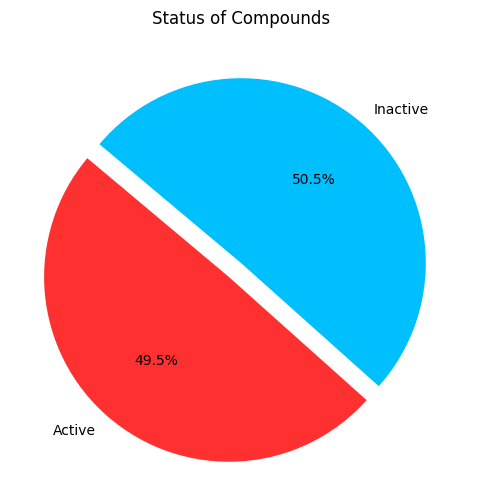

In [33]:
import matplotlib.pyplot as plt

def plot_status(IC50):
    # Calculate number of compounds
    n_compoundsIC50 = len(IC50)

    # Calculate active compounds
    n_ActIC50 = len(IC50[IC50.STATUS == 'active'])

    # Calculate inactive compounds
    n_InactIC50 = len(IC50[IC50.STATUS == 'inactive'])

    # Calculate intermediate compounds
    n_interIC50 = len(IC50[IC50.STATUS == 'intermediate'])

    # Calculate graduation rate
    Active_rateIC50 = (n_ActIC50 / float(n_compoundsIC50)) * 100.

    labels = ['Active', 'Inactive']
    values = [n_ActIC50, n_InactIC50]
    colors = ['#ff3030', '#00bfff']
    explode = (0.1, 0)  # Explode the 1st slice (i.e., 'Active')

    plt.figure(figsize=(6, 6))
    plt.pie(values, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140, explode=explode)
    plt.title('Status of Compounds')

    plt.show()

# Assuming you have your 'data' DataFrame already defined
plot_status(data)


# 1.20 Classification of status of compund by RO5 in the dataset

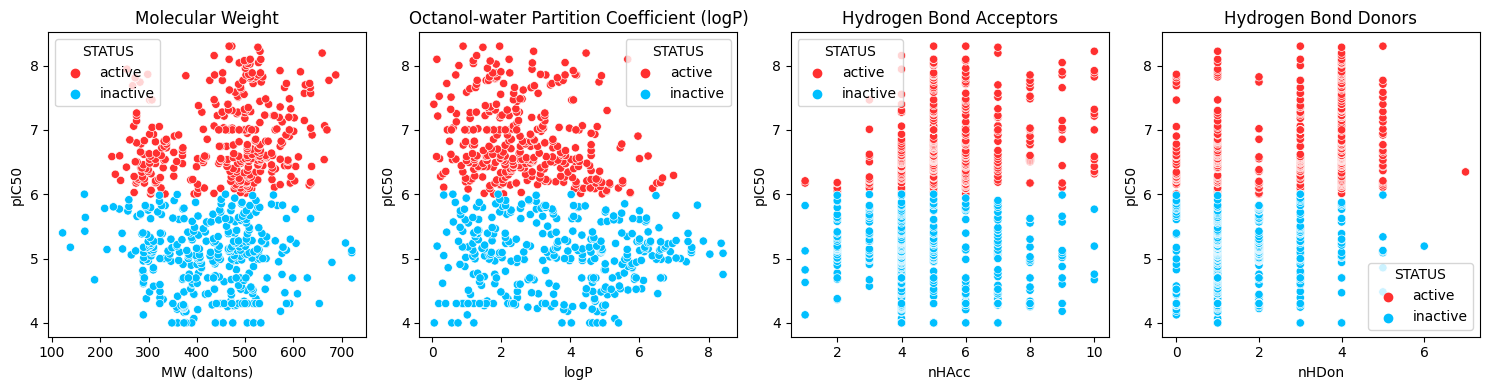

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt

def plotScatterRO5(data):
    plt.figure(figsize=(15, 4))

    plt.subplot(1, 4, 1)
    sns.scatterplot(data=data, x="MW", y="pIC50", hue="STATUS", palette={"active": "#ff3030", "inactive": "#00bfff"})
    plt.xlabel('MW (daltons)')
    plt.ylabel('pIC50')
    plt.title('Molecular Weight')

    plt.subplot(1, 4, 2)
    sns.scatterplot(data=data, x="LogP", y="pIC50", hue="STATUS", palette={"active": "#ff3030", "inactive": "#00bfff"})
    plt.xlabel('logP')
    plt.ylabel('pIC50')
    plt.title('Octanol-water Partition Coefficient (logP)')

    plt.subplot(1, 4, 3)
    sns.scatterplot(data=data, x="nHAcc", y="pIC50", hue="STATUS", palette={"active": "#ff3030", "inactive": "#00bfff"})
    plt.xlabel('nHAcc')
    plt.ylabel('pIC50')
    plt.title('Hydrogen Bond Acceptors')

    plt.subplot(1, 4, 4)
    sns.scatterplot(data=data, x="nHDon", y="pIC50", hue="STATUS", palette={"active": "#ff3030", "inactive": "#00bfff"})
    plt.xlabel('nHDon')
    plt.ylabel('pIC50')
    plt.title('Hydrogen Bond Donors')

    plt.tight_layout()
    plt.show()

plotScatterRO5(data)


# 1.21 PCA analysis of the prepared compound dataset

Explained Variance by Each Component: [0.52947049 0.26310895]
Cumulative Explained Variance: [0.52947049 0.79257944]


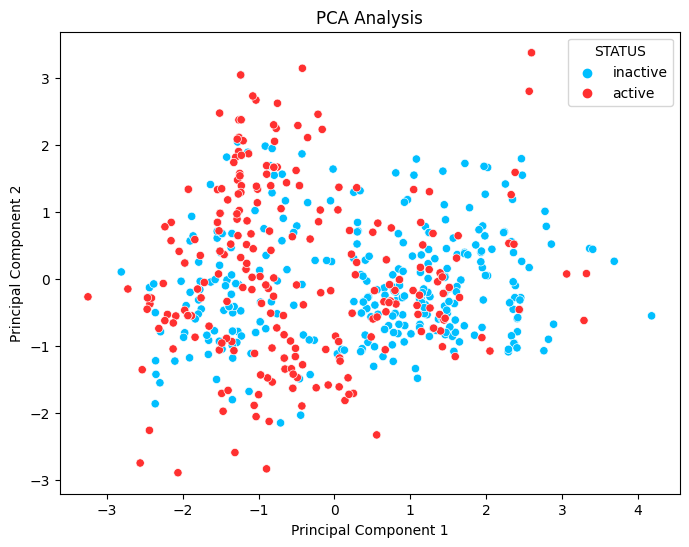

In [35]:
from sklearn.preprocessing import StandardScaler

# Assuming 'data' is your DataFrame
X = data[['MW', 'LogP', 'nHAcc', 'nHDon']].values  # Select the relevant columns
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

from sklearn.decomposition import PCA

pca = PCA(n_components=2)  # Specify the number of components you want
X_pca = pca.fit_transform(X_scaled)

explained_variance = pca.explained_variance_ratio_
print("Explained Variance by Each Component:", explained_variance)
print("Cumulative Explained Variance:", explained_variance.cumsum())

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Create a DataFrame with the reduced data
pca_df = pd.DataFrame(data=X_pca, columns=["PC1", "PC2"])
pca_df['STATUS'] = data['STATUS']

# Create a scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue="STATUS", palette={"active": "#ff3030", "inactive": "#00bfff"})
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA Analysis")
plt.show()


# 1.22 Gen fingerprint into the compound dataset using Pubchem Fingerprint

In [36]:
# Fingerprint

com = data.copy()

def decodeFP(str):
    fp_hex = base64.b64decode(str).hex()
    return '{0:020b}'.format(int(fp_hex[8:], 16))[:-7].zfill(881)

# Request fingerprint from Pubchem
keys = ''
count = 0
fp_raw = pd.DataFrame()
for i in tqdm(com['InChIKey']):
    keys = keys + str(i) + ","
    count = count + 1
    if (count % 100) == 0 or count == len(com['InChIKey']):
        keys = keys[:-1]
        # /inchikey,CanonicalSMILES,IsomericSMILES,Fingerprint2D request parameters
        # inchikey for input type
        resp = requests.get('https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/inchikey/' + keys + '/property/inchikey,CanonicalSMILES,IsomericSMILES,Fingerprint2D/JSON')
        if resp.status_code != 200:
            # This means something went wrong.
            print("Error: " + str((resp.status_code)))
        else:
            keys = ''
            res = resp.json()
            for i in res.values():
                for j in i.values():
                    if j:
                        temp = pd.DataFrame(j)
            fp_raw = fp_raw.append(temp)

col_names = []
for i in range(881):
    col_name = 'PubchemFP' + str(i)
    col_names.append(col_name)
fp = pd.DataFrame(columns=['InChIKey'] + col_names)

fp_list = []
for i in fp_raw['Fingerprint2D'].tolist():
    fp_list.append(decodeFP(i))
fp_raw['hexFP'] = fp_list

merge = pd.merge(com, fp_raw[['InChIKey', 'hexFP']], on='InChIKey', how='inner')
merge.drop_duplicates(subset='InChIKey', keep='first', inplace=True)

display(merge.head())
print("Length: " + str(len(merge)))

  0%|          | 0/699 [00:00<?, ?it/s]<ipython-input-36-87dd103accd3>:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fp_raw = fp_raw.append(temp)
 14%|█▍        | 100/699 [00:01<00:08, 67.53it/s]<ipython-input-36-87dd103accd3>:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fp_raw = fp_raw.append(temp)
 29%|██▊       | 200/699 [00:02<00:07, 69.66it/s]<ipython-input-36-87dd103accd3>:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fp_raw = fp_raw.append(temp)
 43%|████▎     | 300/699 [00:04<00:05, 75.82it/s]<ipython-input-36-87dd103accd3>:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fp_raw = fp_raw.append(temp)
 57%|█████▋   

,action_type,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,assay_variant_accession,assay_variant_mutation,bao_endpoint,...,InChIKey,MW,LogP,nHAcc,nHDon,formula,preferredCompoundName,pIC50,STATUS,hexFP
0,"{'action_type': 'INHIBITOR', 'description': 'N...",NaN,24708087.0,"[{'comments': None, 'relation': '=', 'result_f...",CHEMBL5109237,Inhibition of C-terminal His-tagged SARS-CoV-2...,B,NaN,NaN,BAO_0000190,...,VDCCGGIBUYGMIS-MRXNPFEDSA-N,304.437,4.92342,2.0,1.0,C21H24N2,-,6.004365,active,1110000001111011000000000000000000000000000000...
1,"{'action_type': 'INHIBITOR', 'description': 'N...",NaN,24819134.0,"[{'comments': None, 'relation': '=', 'result_f...",CHEMBL5139921,Inhibition of SARS-CoV-2 papain-like protease ...,B,NaN,NaN,BAO_0000190,...,BESULOSOTMRSOO-UHFFFAOYSA-N,334.233,2.06490,4.0,0.0,C15H13NO3Se,-,6.004365,active,1100000001110010001100000000000000000000000000...
2,"{'action_type': 'INHIBITOR', 'description': 'N...",NaN,24875179.0,"[{'comments': None, 'relation': '=', 'result_f...",CHEMBL5154305,Inhibition of SARS-CoV-2 PLpro expressed in Es...,B,NaN,NaN,BAO_0000190,...,RVXKOLGQSWIVHC-UHFFFAOYSA-N,394.456,1.77990,6.0,2.0,C20H18N4O3S,-,6.004365,active,1110000001111011101100000000000001000100000000...
3,"{'action_type': 'INHIBITOR', 'description': 'N...",NaN,24660864.0,[],CHEMBL5096247,Inhibition of SARS-CoV-2 MPro,B,NaN,NaN,BAO_0000190,...,RJWLAIMXRBDUMH-BRWVUGGUSA-N,401.573,1.50490,5.0,3.0,C19H35N3O4S,-,6.013228,active,1111000001111011001110000000000001000000000000...
4,"{'action_type': 'INHIBITOR', 'description': 'N...",NaN,24708033.0,[],CHEMBL5109230,Inhibition of SARS-CoV-2 PLpro,B,NaN,NaN,BAO_0000190,...,IQVFCZXMGASAGI-OAHLLOKOSA-N,435.549,4.29642,5.0,4.0,C24H25N3O3S,-,6.013228,active,1110000001111011001100000000000001000000000000...


Length: 698


# 1.23 Check compound couldn't gen fingerprint

In [37]:
# Compound that could not be found in PubChem API
diff = com[com['InChIKey'].isin(list(set(com['InChIKey'].tolist()) - set(fp_raw['InChIKey'].tolist())))]
display(diff.head())
print("Length: " + str(len(diff)))

,action_type,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,assay_variant_accession,assay_variant_mutation,bao_endpoint,...,mol,InChIKey,MW,LogP,nHAcc,nHDon,formula,preferredCompoundName,pIC50,STATUS
138,"{'action_type': 'INHIBITOR', 'description': 'N...",NaN,24890463.0,"[{'comments': None, 'relation': '=', 'result_f...",CHEMBL5158332,Inhibition of SARS-CoV-2 3CL protease using MC...,B,NaN,NaN,BAO_0000190,...,<rdkit.Chem.rdchem.Mol object at 0x789cf7a435a0>,FOIMPAZRZOEHDI-STZFKDTASA-N,435.234,1.50648,7.0,3.0,C17H15BrN4O5,-,4.719194,inactive


Length: 1


# 1.24 Save dataset with Pubchem Fingerprint ('InChiKey' + 'PubchemFP') in csv formate

In [38]:
# Save csv Pubchem Fingerprint
### From Pubchem API ###
compound_index = 0
fp_index = 1
simple = []
for i in tqdm(range(len(merge['hexFP']))):
    fp_index = 1
    simple.append([merge.iloc[i]['InChIKey']] + list(merge.iloc[i]['hexFP']))
final_fp = pd.DataFrame(simple, columns=['InChIKey'] + col_names)

final_fp.to_csv(os.path.join(path, 'PubchemFingerprinter_'+title+'_'+thresholdName+'.csv'), index=False)
display(final_fp.head())
print("Length: " + str(len(final_fp)))

100%|██████████| 698/698 [00:00<00:00, 3653.84it/s]


,InChIKey,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,...,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880
0,VDCCGGIBUYGMIS-MRXNPFEDSA-N,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,BESULOSOTMRSOO-UHFFFAOYSA-N,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,RVXKOLGQSWIVHC-UHFFFAOYSA-N,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,RJWLAIMXRBDUMH-BRWVUGGUSA-N,1,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,IQVFCZXMGASAGI-OAHLLOKOSA-N,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Length: 698


In [52]:
Status_data = pd.read_csv(os.path.join(path, targetName+'_'+title+'_'+thresholdName+'_Final.csv'), header=0)
Status_data = Status_data[['InChIKey', 'STATUS']]

for Fingerprints in glob.glob(os.path.join(path, 'PubchemFingerprinter_'+title+'_'+thresholdName+'.csv')):
  Fp = pd.read_csv(Fingerprints)
  Fp_name = os.path.basename(Fingerprints)

  # Fp_name = Fp.replace(".csv", "")
  # print ('')
  # print ('In %s dataset...' % (Fp_name))
  # print ("There are %d status and %d fingerprint." % (len(Status_data), len(Fp)))

  Fp = Fp.rename(columns={'Name': 'InChIKey'})
  raw = Status_data.merge(Fp, on='InChIKey', how='inner')

  # Merge with "pIC50" column from the "merge" DataFrame
  raw = raw.merge(merge[['InChIKey', 'pIC50']], on='InChIKey', how='left')

  # Transform STATUS
  sta = []
  for i in raw.STATUS:
      if i == 'active':
          sta.append(1)  # active
      elif i == 'inactive':
          sta.append(-1)  # inactive
      elif i == 'intermediate':
          sta.append(0)  # intermediate
  raw = raw.drop('STATUS', 1)
  raw["Status"] = sta

  raw = raw.sort_values(by=['InChIKey'])
  raw.to_csv(os.path.join(path, Fp_name), sep=',', index=False)
  display(raw.head())
  print("Length: " + str(len(raw)))

<ipython-input-52-fae37d96ae12>:28: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  raw = raw.drop('STATUS', 1)


,InChIKey,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,...,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880,Status,pIC50
547,AAGWZGZFZQICGA-UHFFFAOYSA-N,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,-1,5.325139
519,AAVJURZPPGLDNV-UHFFFAOYSA-N,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,-1,5.227678
503,ADFWQBGTDJIESE-UHFFFAOYSA-N,1,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,-1,5.167491
366,AEPGJISBJNWRCC-RZUBCFFCSA-N,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,-1,4.340084
311,AFBHFYNKGPHTHJ-AWEZNQCLSA-N,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,7.853872


Length: 698


# 1.25 Remove useless descriptor and save final preprocessing data ready for ML model training

In [62]:
def Remove_useless_descriptor(data, threshold):
    data2 = (data.drop('Status', axis=1))

    des1 = len(data2.columns)

    h = data2.columns.tolist()
    df = data2.values.astype(np.float)
    df = np.array(df)

    STDEV = np.std(df, axis=0)
    idx = [idx for idx, val in enumerate(STDEV) if val > threshold]
    df2 = df[:, idx]
    hx = np.array(h)[idx]

    df = pd.DataFrame(df2, columns=[hx])

    des2 = len(df.columns)

    df['Status'] = data['Status']

    # print ('from Remove useless descriptor...')
    # print ("The initial set of %d descriptors has been reduced to %d descriptors." % (des1, des2))

    return df, des1, des2

Fingerprints = (os.path.join(path, "PubchemFingerprinter_"+title+'_'+thresholdName+".csv"))
data = pd.read_csv(Fingerprints)

Fp_name = os.path.basename(Fingerprints)
Fp_name = Fp_name.replace(".csv", "")
Fp_name = Fp_name.replace("PubchemFingerprinter_", "")

data = data.iloc[:, 1:]
data = data.drop(data.index[data.Status == 0])
data.index = range(len(data))

data, des1, des2 = Remove_useless_descriptor(data, 0.05)  # Remove correlation cut off 95%
display(data.head())
print("Length: " + str(len(data)))
print("Before removal: " + str(des1))
print("After removal: " + str(des2))

final_data = data.drop(columns='Status')
final_data
display(final_data.head())

from google.colab import files
final_data.to_csv('final_data_drop_useless.csv', encoding = 'utf-8-sig')
files.download('final_data_drop_useless.csv')

<ipython-input-62-5469178c985e>:7: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  df = data2.values.astype(np.float)


,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP6,PubchemFP11,PubchemFP12,PubchemFP13,PubchemFP14,PubchemFP15,PubchemFP16,...,PubchemFP833,PubchemFP834,PubchemFP835,PubchemFP836,PubchemFP839,PubchemFP840,PubchemFP847,PubchemFP860,pIC50,Status
0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.325139,-1
1,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.227678,-1
2,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.167491,-1
3,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.340084,-1
4,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.853872,1


Length: 698
Before removal: 882
After removal: 546


<ipython-input-62-5469178c985e>:43: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  final_data = data.drop(columns='Status')


,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP6,PubchemFP11,PubchemFP12,PubchemFP13,PubchemFP14,PubchemFP15,PubchemFP16,...,PubchemFP830,PubchemFP833,PubchemFP834,PubchemFP835,PubchemFP836,PubchemFP839,PubchemFP840,PubchemFP847,PubchemFP860,pIC50
0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.325139
1,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.227678
2,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.167491
3,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.340084
4,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.853872


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# **2. Build Machine Learning and train the model using Pycaret**

# 2.1 Install dependencies and import libraries for ML model

In [63]:
!pip install pycaret[full]
from pycaret.regression import *
import pandas as pd
from yellowbrick.regressor import PredictionError, ResidualsPlot

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 484.7/484.7 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 63.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.4/73.4 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 68.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.5/160.5 kB 16.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.8/106.8 kB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 23.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 61.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.8/101.8 kB 9.7 MB/

# 2.2 Setup parameter for Machine Learning (ML) model training

In [17]:
# import pycaret regression and init setup
from pycaret.regression import *
import pandas as pd
ML_data = pd.read_csv('/content/final_data_drop_useless.csv')
ML_data_clean = ML_data.drop(columns='Unnamed: 0')
from sklearn.model_selection import train_test_split
train, test = train_test_split(ML_data_clean, test_size=0.20)
s = setup(ML_data_clean, target = 'pIC50', session_id = 123, use_gpu=True)

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of

,Description,Value
0,Session id,123
1,Target,pIC50
2,Target type,Regression
3,Original data shape,"(698, 546)"
4,Transformed data shape,"(698, 546)"
5,Transformed train set shape,"(488, 546)"
6,Transformed test set shape,"(210, 546)"
7,Numeric features,545
8,Preprocess,True
9,Imputation type,simple


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of

# 2.3 Compare Machine Learning model

In [18]:
# compare baseline models
best = compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.4548,0.4010,0.6268,0.6435,0.0924,0.0802,0.1470
rf,Random Forest Regressor,0.4519,0.4113,0.6366,0.6329,0.0933,0.0793,1.5010
gbr,Gradient Boosting Regressor,0.4889,0.4603,0.6676,0.5909,0.0987,0.0869,0.8610
knn,K Neighbors Regressor,0.4878,0.4641,0.6703,0.5843,0.0971,0.0854,0.2020
xgboost,Extreme Gradient Boosting,0.4656,0.4750,0.6820,0.5745,0.1002,0.0811,1.1980
br,Bayesian Ridge,0.5118,0.4841,0.6851,0.5679,0.1014,0.0906,0.2780
ada,AdaBoost Regressor,0.6181,0.5927,0.7651,0.4688,0.1115,0.1070,0.3100
ridge,Ridge Regression,0.5702,0.6187,0.7786,0.4391,0.1174,0.1000,0.2140
omp,Orthogonal Matching Pursuit,0.5934,0.6361,0.7900,0.4231,0.1170,0.1046,0.0800
et,Extra Trees Regressor,0.5608,0.6527,0.7996,0.4136,0.1176,0.0974,2.1980


Processing:   0%|          | 0/85 [00:00<?, ?it/s]

# 2.4 ML model evaluation

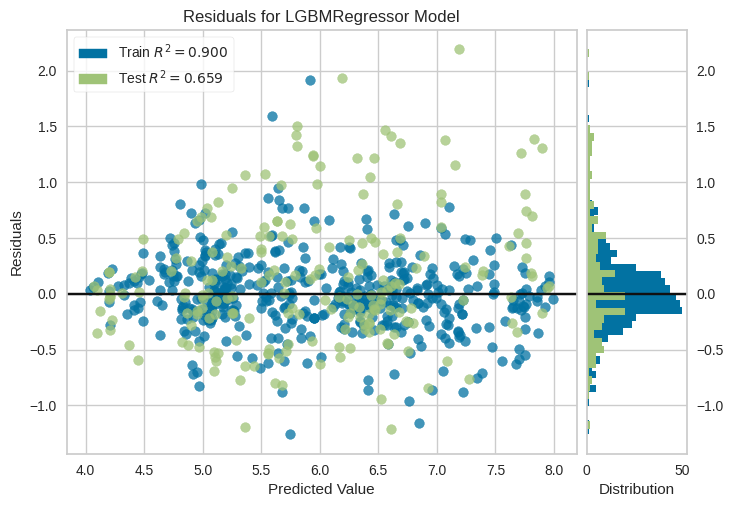

In [19]:
# plot residuals
plot_model(best, plot = 'residuals')

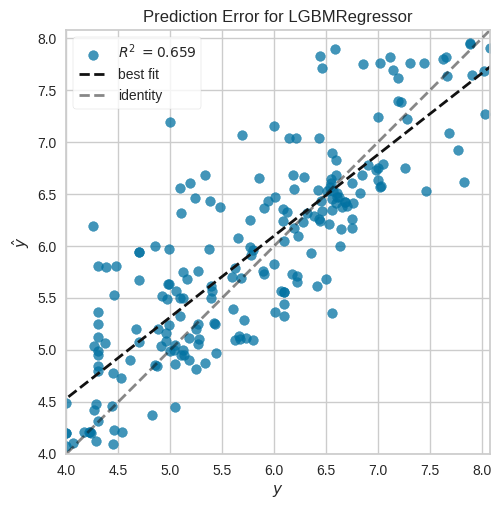

In [20]:
# plot error
plot_model(best, plot = 'error')

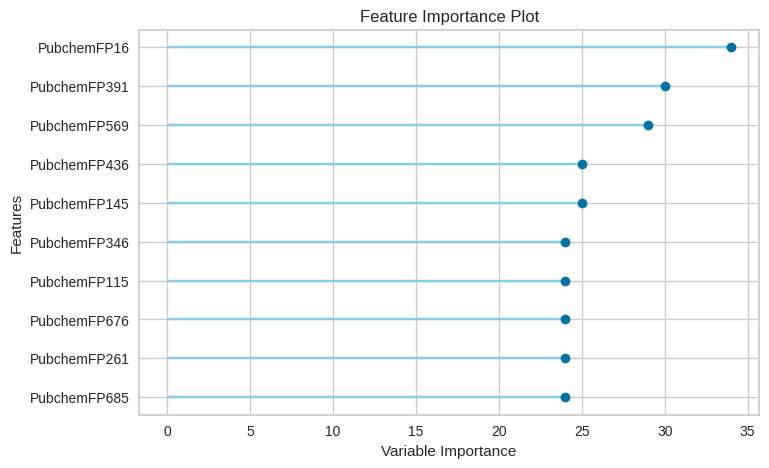

In [21]:
# plot feature importance
plot_model(best, plot = 'feature')

# 2.5 Creat model

In [22]:
# train linear regression with default fold=10
model = create_model('lightgbm', return_train_score=True)

Processing:   0%|          | 0/4 [00:00<?, ?it/s]

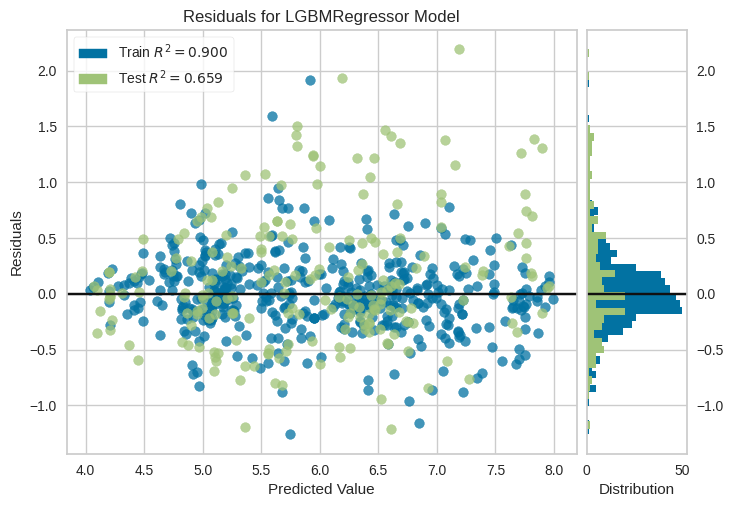

In [23]:
# plot residuals
plot_model(model, plot = 'residuals')

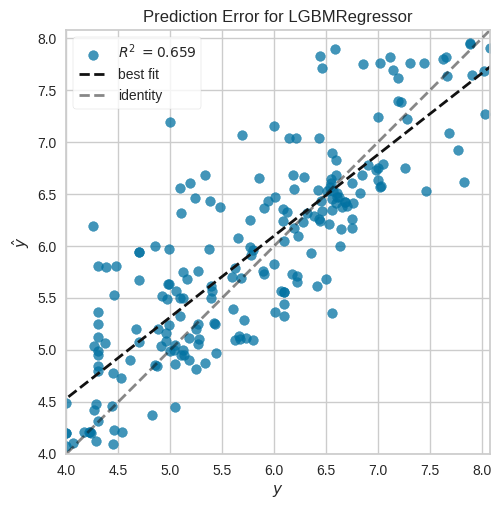

In [24]:
# plot error
plot_model(model, plot = 'error')

# 2.6 Prediction of new data

In [25]:
# predict model on new_data
new_data = pd.read_csv('/content/descriptors_output_G4L_iML_filetered_RO5.csv')
predictions = predict_model(model, data = new_data)
predictions.head()

,Name,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,...,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880,prediction_label
0,G4L0100,1,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5.983291
1,G4L0101,1,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5.836987
2,G4L0465,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,6.065022
3,G4L0477,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5.508875
4,G4L0478,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5.508875


In [26]:
predictions
from google.colab import files
predictions.to_csv('predicted_output_filtered_RO5_G4L_iML.csv', encoding = 'utf-8-sig')
files.download('predicted_output_filtered_RO5_G4L_iML.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# 2.7 Fine-tune model

In [27]:
# define tuning grid
# tune model with custom grid and metric = R2

dt_grid = {'max_depth' : [None, 2, 4, 6, 8, 10, 12, 14, 16, 18]}
tuned_model = tune_model(model, custom_grid = dt_grid, optimize ='R2', return_train_score=True, n_iter = 100)

Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


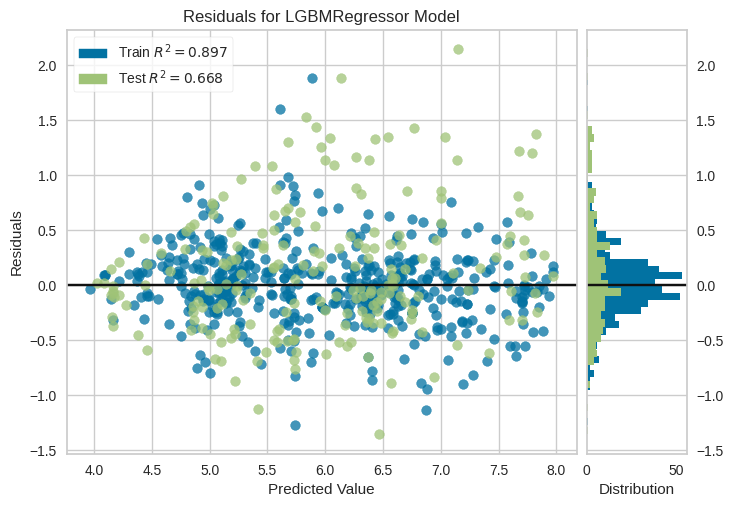

In [28]:
# plot residuals
plot_model(tuned_model, plot = 'residuals')

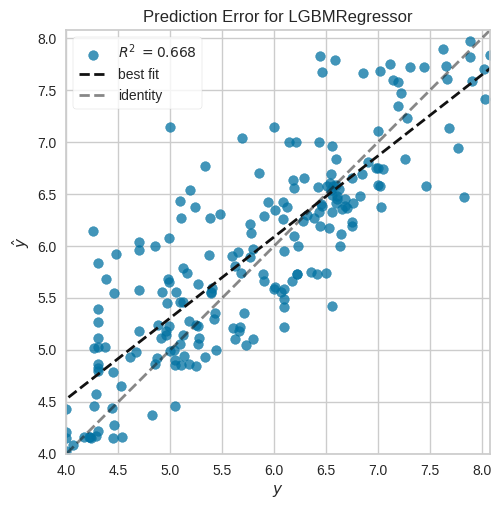

In [30]:
# plot error
plot_model(tuned_model, plot = 'error')

# 2.8 fine-tuned model predioction with new data

In [31]:
# predict model on new_data
new_data = pd.read_csv('/content/descriptors_output_G4L_iML_filetered_RO5.csv')
predictions = predict_model(tuned_model, data = new_data)
predictions.head()

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


,Name,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,...,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880,prediction_label
0,G4L0100,1,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5.953854
1,G4L0101,1,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5.821488
2,G4L0465,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,6.011107
3,G4L0477,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5.501673
4,G4L0478,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5.501673


In [32]:
predictions
from google.colab import files
predictions.to_csv('predicted_output_filtered_RO5_G4L_iML.csv', encoding = 'utf-8-sig')
files.download('predicted_output_filtered_RO5_G4L_iML.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# 2.9 Finalzed ML model

In [33]:
final_best = finalize_model(tuned_model)
final_best

Pipeline(memory=Memory(location=None),
         steps=[('numerical_imputer',
                 TransformerWrapper(include=['PubchemFP1', 'PubchemFP2',
                                             'PubchemFP3', 'PubchemFP6',
                                             'PubchemFP11', 'PubchemFP12',
                                             'PubchemFP13', 'PubchemFP14',
                                             'PubchemFP15', 'PubchemFP16',
                                             'PubchemFP17', 'PubchemFP18',
                                             'PubchemFP19', 'PubchemFP20',
                                             'PubchemFP21', 'PubchemFP23',
                                             'PubchemFP24', 'PubchemFP25',
                                             'Pubchem...
                                             'PubchemFP34', 'PubchemFP35',
                                             'PubchemFP37', 'PubchemFP38',
                                             'PubchemFP43', 'PubchemFP44',
                                             'PubchemFP66', 'PubchemFP115',
                                             'PubchemFP116', 'PubchemFP118', ...],
                                    transformer=SimpleImputer())),
                ('categorical_imputer',
                 TransformerWrapper(include=[],
                                    transformer=SimpleImputer(strategy='most_frequent'))),
                ('actual_estimator',
                 LGBMRegressor(max_depth=10, n_jobs=-1, random_state=123))])